In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [9]:
data = pd.read_csv(f'C:\\Users\\juanp\\OneDrive\\Desktop\\CURSO TURING\\propiedades_limpias.csv', sep=',', encoding='utf-8-sig')
print(data.shape)

(479, 10)


In [10]:
data.head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final
0,3300000000,"envigado, loma del escobero, palmas",4,4,2,450.0,zonas tranquilas exclusivas retiro antioquia e...,Casa campestre en venta,loma escobero,cali
1,350000000,"solares de morada vii y viii, br senderos de m...",2,3,2,100.0,hermosa casa castillo zona jamundí sur ciudad ...,Casa en venta,hacienda castillo,cali
2,1200000000,"calera, plazuela, alto de virgen",4,8,12,5127.0,expectacular casafinca campestre vía bogotá ca...,Casa campestre en venta,centro,bogota
3,194000000,"loma del atravesado, palmas, mesa",3,1,No encontrado,78.0,encantadora casa cuenta servicios completos in...,Casa en venta,vereda planta,medellin
4,1290000000,"bogota, monaco, puente largo",4,3,2,445.0,NaN,Casa en venta,niza,bogota


Se sugiere eliminar georeferencia ya que a pesar de tener datos utiles para detectar su cuidad estos tampoco siguen una estructura y al ser solo nombres de ubicaciones al azar (318) lo maximo que se repite un valor despues de normalizar es de 20 esto va a añadir ruido a futuros modelos.

In [4]:
data['georeferencia'].value_counts()

georeferencia
san antonio prado                     19
poblado                               12
rionegro                              12
centro                                11
laureles                              11
                                      ..
villa adriana                          1
punto mayor                            1
mesa                                   1
belen nubia                            1
parque industrial portos sabana 80     1
Name: count, Length: 318, dtype: int64

In [5]:
num_cols = ['habitaciones', 'baños', 'parqueaderos', 'area']
cat_cols = ['ciudad_final', 'tipo_propiedad', 'descripcion', "ubicacion", 'georeferencia']
target = 'precio'
#data = data.drop(columns=['georeferencia'])

In [6]:
data[num_cols] = data[num_cols].replace('No encontrado', np.nan)
data[cat_cols] = data[cat_cols].replace('No encontrado', np.nan)
# 3) Convertir a tipo numérico
data[num_cols] = data[num_cols].astype(float)

In [7]:
# Buscando valores vacios
data.isnull().sum()

precio             0
ubicacion          0
habitaciones       9
baños             25
parqueaderos      98
area               8
descripcion       27
tipo_propiedad     0
georeferencia      0
ciudad_final       0
dtype: int64

Non-numeric strings:

Examples: "abc", "unknown", "N/A", "No encontrado", "--".
These cannot be interpreted as numbers.
Mixed data types:

Examples: "123abc", "45.67%", "1,000".
These contain numeric characters but also include non-numeric characters, making them invalid.
Empty strings:

Example: "".
An empty string is not a valid numeric value.
Whitespace-only strings:

Example: "   ".
Strings with only spaces or tabs are invalid.
Special characters:

Examples: "@", "#", "!".
These are not numeric values.
Malformed numbers:

Examples: "1.2.3", "123,456.78.90".
These do not follow a valid numeric format.
Non-standard numeric formats:

Examples: "1,000" (if commas are not handled), "1e3" (scientific notation, if not expected).

In [8]:
def limpiar_columna_numerica(df, columna):
    """Limpia y convierte una columna a numérica."""
    df[columna] = pd.to_numeric(df[columna], errors='coerce')  # 'coerce' convierte no válidos a NaN
    return df

for col in num_cols:
    limpiar_columna_numerica(data, col)

# Viendo que valores quedaron como nulos
data.isnull().sum()

precio             0
ubicacion          0
habitaciones       9
baños             25
parqueaderos      98
area               8
descripcion       27
tipo_propiedad     0
georeferencia      0
ciudad_final       0
dtype: int64

In [9]:
#data[~data['area'].apply(lambda x: isinstance(x, (int, float))) & data['area'].notnull()] Check if there are non-numeric values in the 'area' column



Por que se esta haciendo esto? <br>
Primero que todo se va a tokenizar la columna posteriormente y este no puede tener valores faltantes, <br>
despues, se va a eliminar las filas que tengan mas de X valores faltantes, en este caso 3, ya que no se puede hacer nada con esas filas <br>
Y realmente no hay manera de saber tratar datos de este tipo de lenguaje natural de alguna manera entonces es mejor llenarlos con algo para que por ahora al procesamiento que se esta haciendo no presente problemas


In [10]:
# A pesar de no poder hacer nada con la descripcion, no se va a eliminar dado que eliminarlo quitaria mas datos de la base de datos con otras columnas que si se pueden usar
data['descripcion'] = data['descripcion'].fillna("")

Realizamos un primer analisis a los datos con los datos faltantes y sin tratamiento para outliers

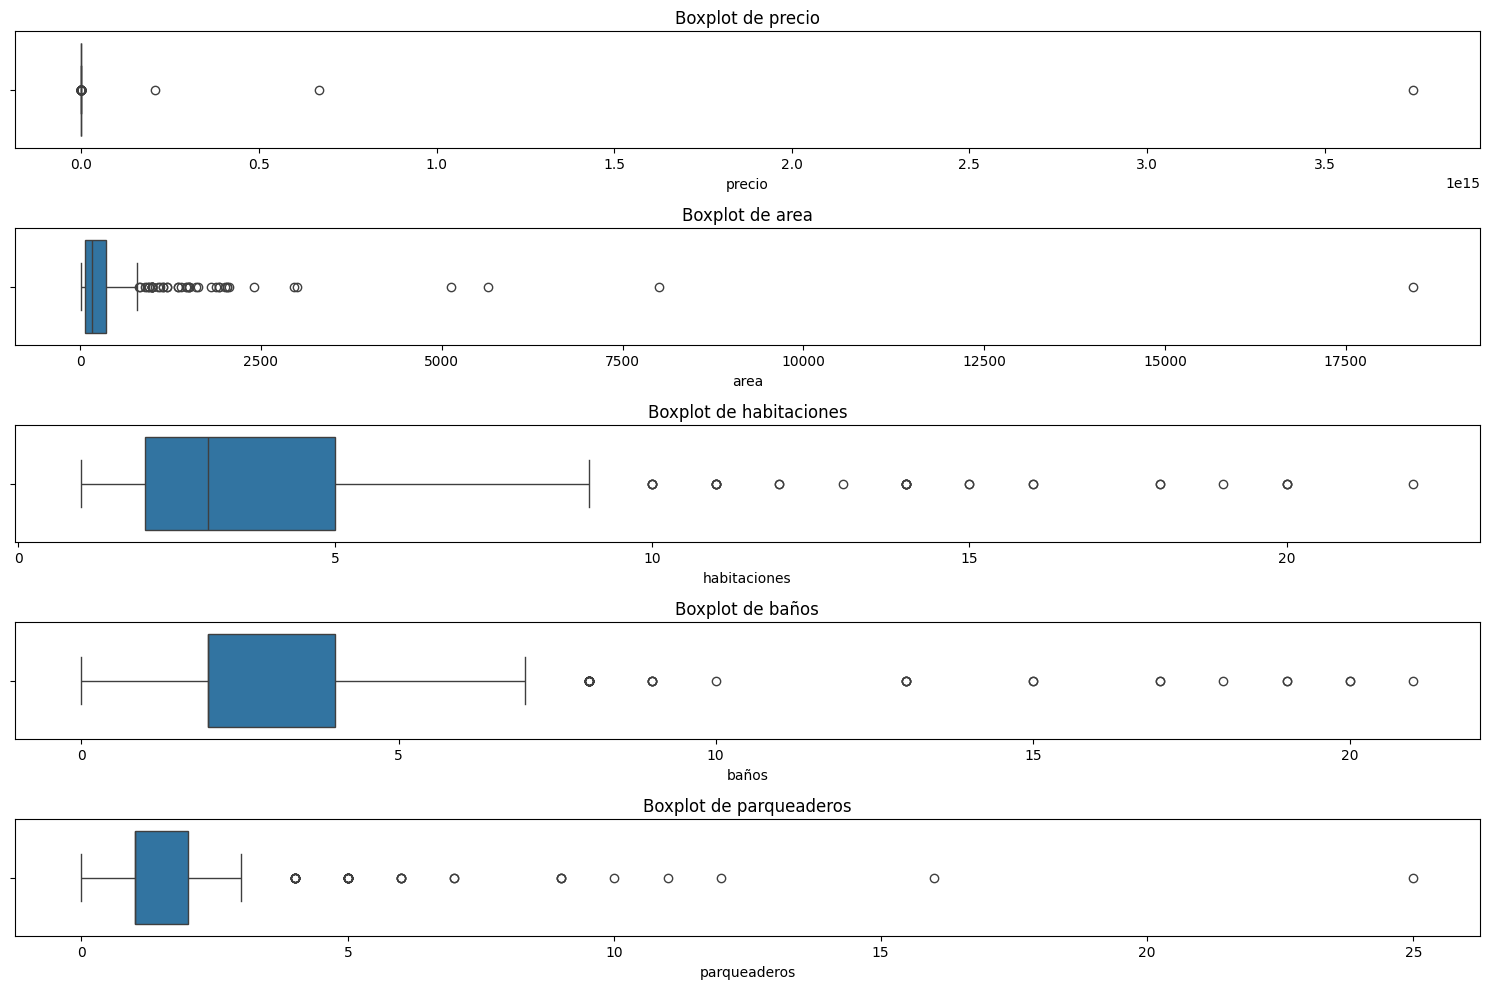

             precio          area  habitaciones       baños  parqueaderos
count  4.790000e+02    471.000000    470.000000  454.000000    381.000000
mean   9.660445e+12    387.477091      4.138298    3.352423      1.669291
std    1.742210e+14   1049.217757      3.240867    3.205133      2.225646
min    7.000000e+05     19.000000      1.000000    0.000000      0.000000
25%    4.500000e+06     70.150000      2.000000    2.000000      1.000000
50%    1.700000e+07    164.000000      3.000000    2.000000      1.000000
75%    3.000000e+08    360.000000      5.000000    4.000000      2.000000
max    3.750000e+15  18433.980000     22.000000   21.000000     25.000000


In [11]:
def plot_outliers(data, cols):
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(cols, 1):
        plt.subplot(len(cols), 1, i)
        sns.boxplot(x=data[col])
        plt.title(f'Boxplot de {col}')
    plt.tight_layout()
    plt.show()
    
    # También mostramos estadísticas descriptivas
    print(data[cols].describe())

# Visualizar outliers en variables numéricas
plot_outliers(data, ['precio', 'area', 'habitaciones', 'baños', 'parqueaderos'])


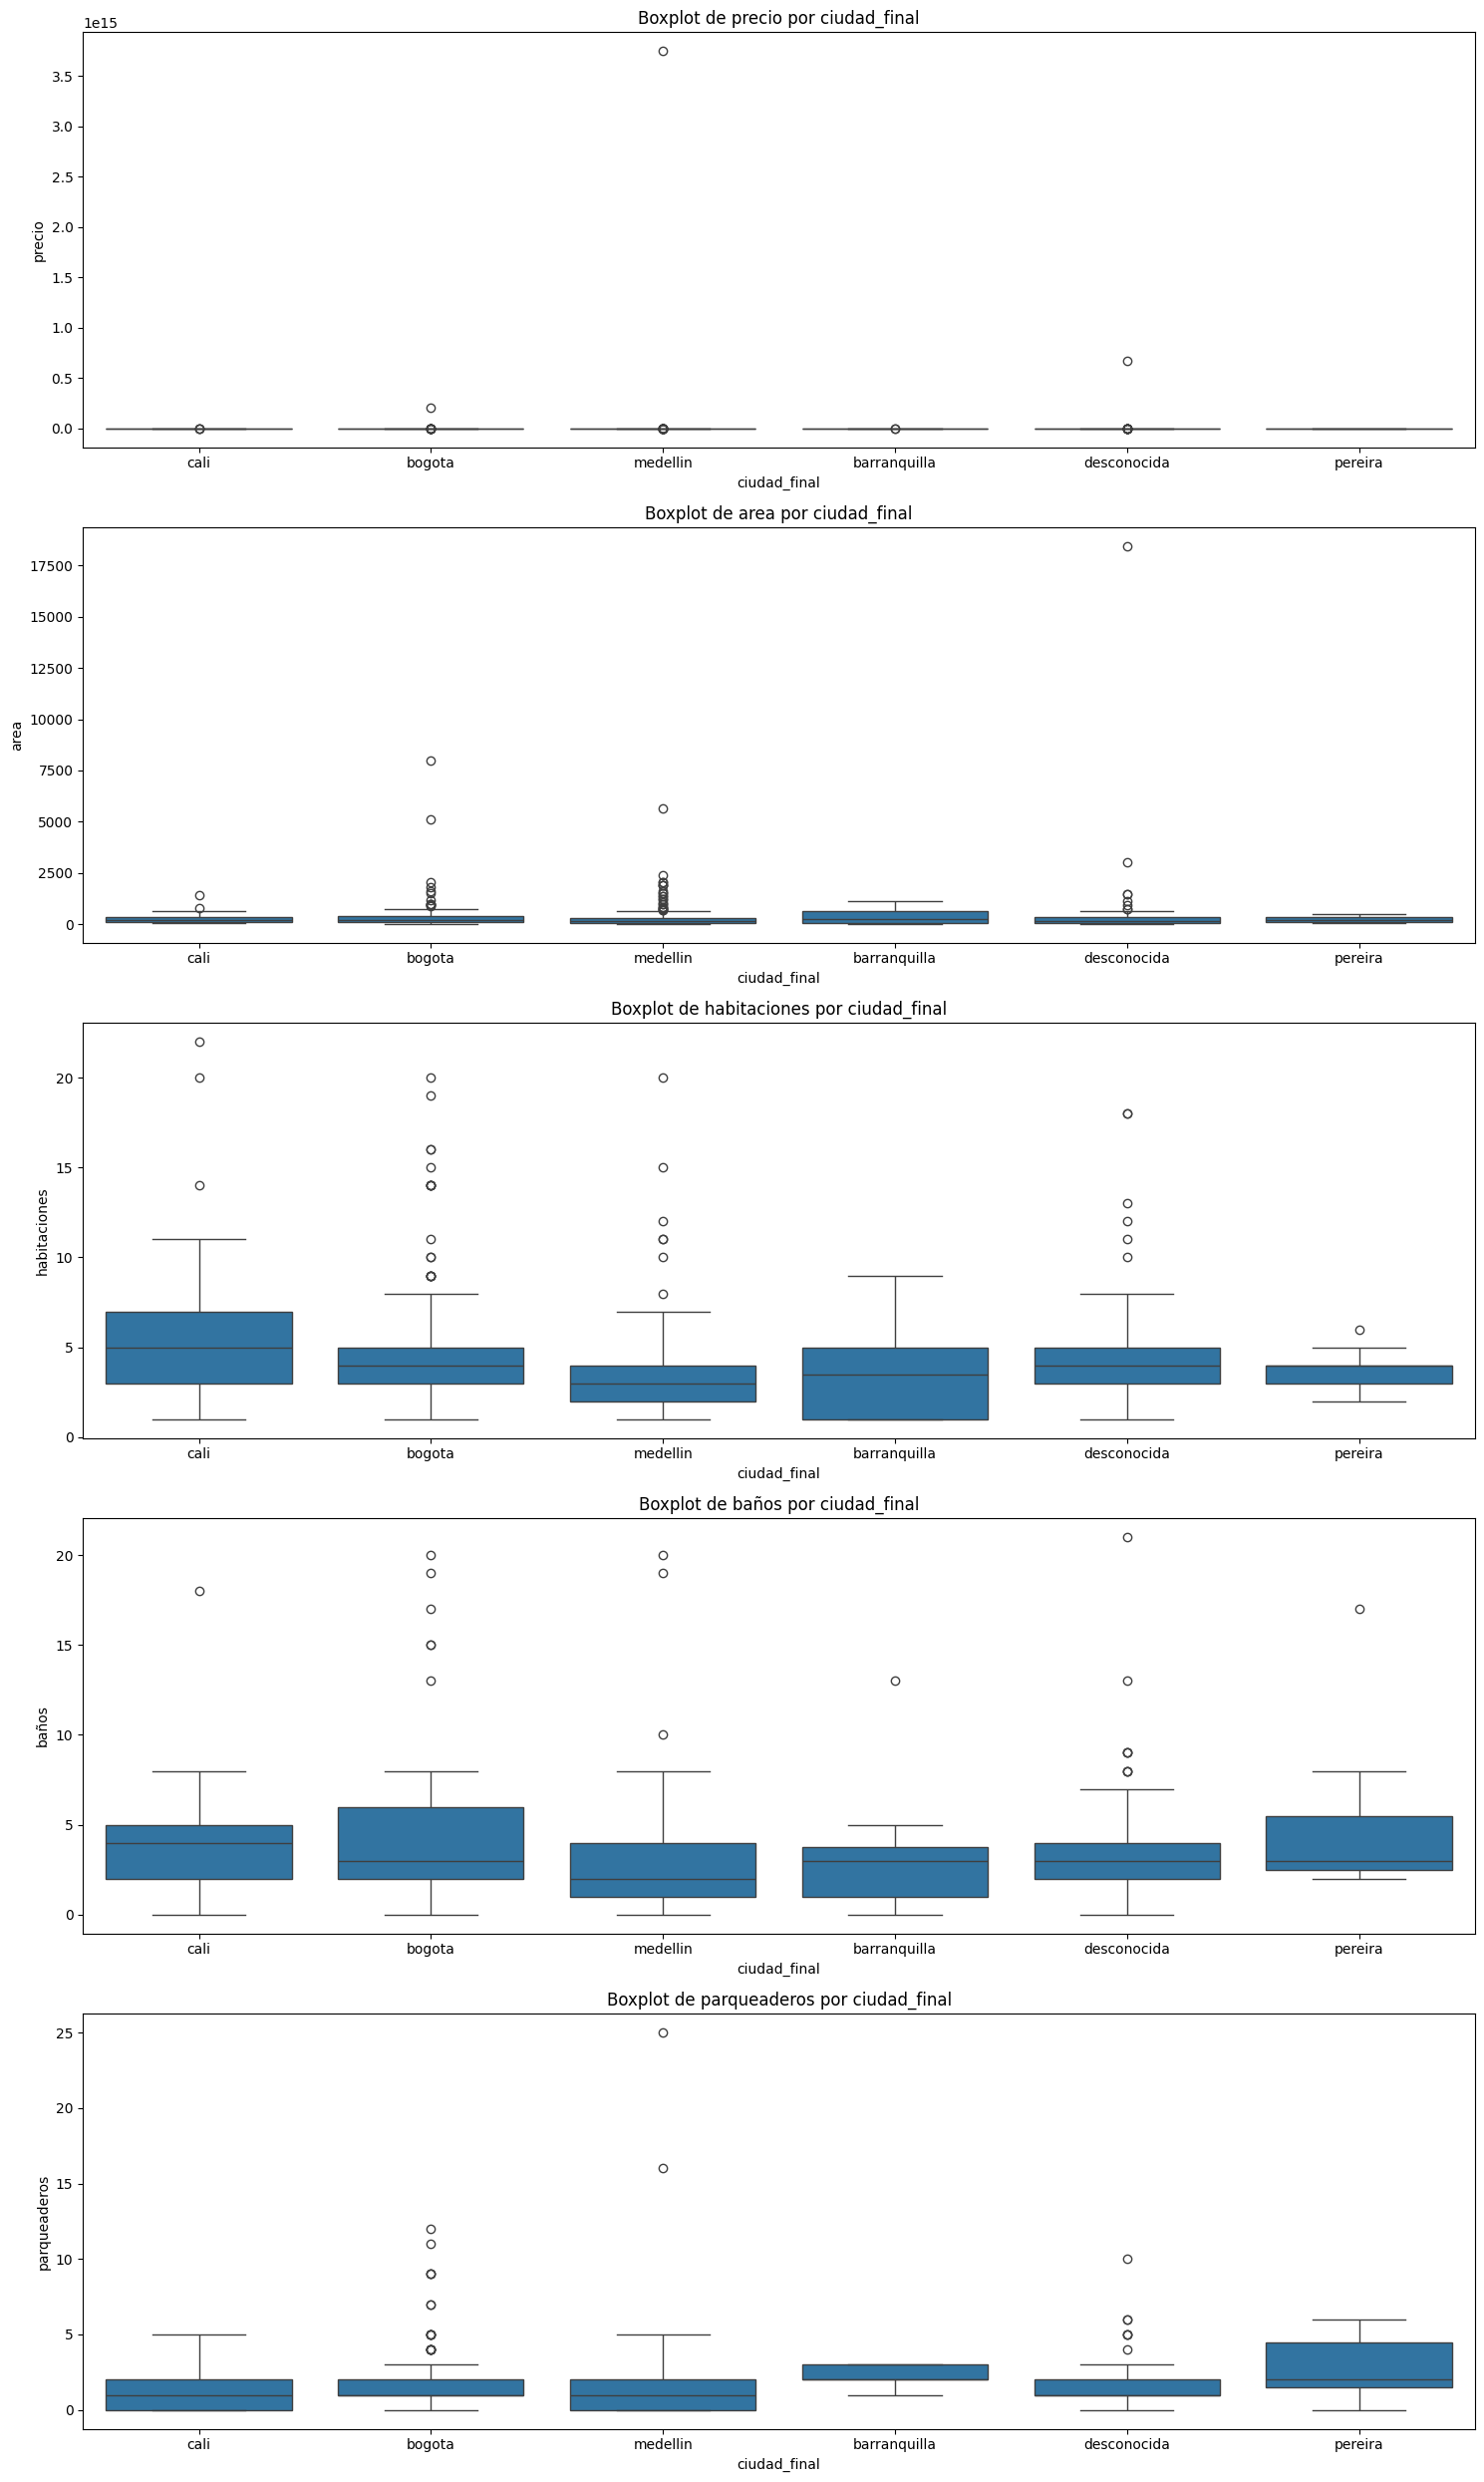

In [12]:
# Detección de outliers usando IQR (Rango Intercuartílico)
def detect_outliers_iqr(data, columns, factor=1.5):
    outliers = {}
    for col in columns:
        if data[col].dtype in ['int64', 'float64']:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)].index.tolist()
    return outliers


def plot_and_detect_outliers_per_city(
    data: pd.DataFrame,
    cols: list,
    city_col: str = 'ciudad_final',
    min_count: int = 5
) -> pd.DataFrame:
    """
    For each numeric column in `cols`, plots boxplots grouped by city (`city_col`)
    and computes outlier counts and percentages per city using the IQR method.

    Parameters:
    - data: input DataFrame
    - cols: list of numeric column names to analyze
    - city_col: name of the city/grouping column
    - min_count: minimum number of observations required to include a city

    Returns:
    - summary_df: DataFrame with outlier counts and percentages for each city and variable
    """
    # Select cities with enough data
    counts = data[city_col].value_counts()
    valid_cities = counts[counts >= min_count].index
    subset = data[data[city_col].isin(valid_cities)]

    # Prepare plotting
    n = len(cols)
    fig, axes = plt.subplots(n, 1, figsize=(15, 5 * n), sharex=False)
    if n == 1:
        axes = [axes]

    # Collect summary info
    records = []

    for ax, col in zip(axes, cols):
        # Boxplot by city
        sns.boxplot(x=city_col, y=col, data=subset, ax=ax)
        ax.set_title(f'Boxplot de {col} por {city_col}')
        ax.set_xlabel(city_col)
        ax.set_ylabel(col)

        # Detect outliers per city
        for city in valid_cities:
            city_vals = subset.loc[subset[city_col] == city, col]
            outliers = detect_outliers_iqr(data,['precio', 'area', 'habitaciones', 'baños', 'parqueaderos'])
            total = len(city_vals)
            out_count = len(outliers)
            records.append({
                city_col: city,
                'variable': col,
                'n_obs': total,
                'outliers_count': out_count
            })

    plt.tight_layout()
    plt.show()

plot_and_detect_outliers_per_city(data, ['precio', 'area', 'habitaciones', 'baños', 'parqueaderos'], city_col='ciudad_final', min_count=5)

In [13]:
# Caracteristica extra util para el modelo y para la deteccion de outliers
data['precio_por_m2'] = data['precio'] / data['area']

In [14]:
# Detección de outliers usando Z-score
def detect_outliers_zscore(data, columns, threshold=2):
    outliers = {}
    for col in columns:
        if data[col].dtype in ['int64', 'float64']:
            z_scores = stats.zscore(data[col], nan_policy='omit')
            outliers[col] = data[abs(z_scores) > threshold].index.tolist()
    return outliers

# Aplicar ambos métodos
outliers_zscore = detect_outliers_zscore(data, ['precio', 'area', 'precio_por_m2', 'habitaciones', 'baños', 'parqueaderos'], threshold=2)
outliers_iqr = detect_outliers_iqr(data, ['precio', 'area', 'precio_por_m2', 'habitaciones', 'baños', 'parqueaderos'])
print(f"Outliers detectados con Z-score en precio: {len(outliers_zscore['precio'])}")
print(f"Outliers detectados con IQR en precio: {len(outliers_iqr['precio'])}")

Outliers detectados con Z-score en precio: 2
Outliers detectados con IQR en precio: 65


Para el tratamiento de outliers hay que tener en cuenta el contexto, analizar la base de datos completa no esta mal y nos da un primer acercamiento pero es valido segmentar la base de datos por caracteristicas comunes para realizar el tratamiento de outliers, tambien se pueden realizar la creacion de caracteristicas que nos permitan analizar variables de interes pero se tiene que analizar que haya significancia en la relacion, esto se puede hacer con un analisis de regresion simple

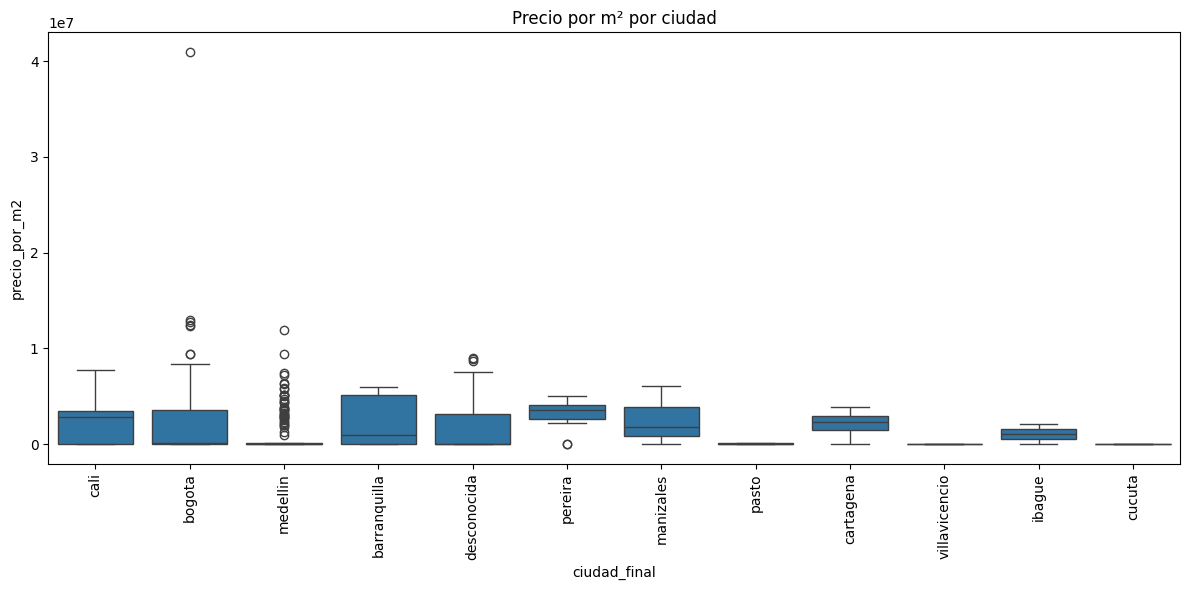

In [15]:
# Visualizar precio por m² por ciudad
plt.figure(figsize=(12, 6))
sns.boxplot(x='ciudad_final', y='precio_por_m2', data=data)
plt.xticks(rotation=90)
plt.title('Precio por m² por ciudad')
plt.tight_layout()
plt.show()



## Detección y eliminación de outliers extremos

Remover las observaciones con valores atípicos muy extremos en cualquiera de las variables numéricas, y mantener un registro separado de cuáles filas y en qué columnas se detectaron para su revisión posterior.

---

### Qué hacemos  
1. **Contamos filas iniciales** para medir el impacto de la operación.  
2. **Iteramos** sobre cada columna numérica (`float64`, `int64`).  
3. **Calculamos el Z-score** (valor estándar) de cada punto y marcamos los índices cuyo Z-score supere un umbral (por defecto, 5 o sea que toma como outlier los datos que se encuentre a mas de 5 desviaciones estandar).  Esto se basa en la regla empírica, que establece que: ~99,7 % de los datos en una distribución normal se encuentran dentro de 3 desviaciones estándar de la media. Entre mas alto el valor menos estricto.
4. **Registramos** para cada fila outlier en qué columna(s) se detectó.  
5. **Creamos un DataFrame** `outliers_df` con esas filas y una columna adicional `outlier_in` que lista las variables responsables.  
6. **Eliminamos** dichas filas del DataFrame original para obtener `data_filtered`.  
7. **Imprimimos** cuántas filas se eliminaron y su porcentaje relativo.  
8. **Devolvemos** el DataFrame limpio y el DataFrame de outliers con sus metadatos.

---

### Por qué  
- Valores con Z-score muy alto suelen corresponder a errores de captura, unidades heterogéneas o casos verdaderamente atípicos que distorsionan estadísticas y modelos.  
- Separarlos permite:  
  - **Inspección manual** de outliers antes de decidir imputación o corrección.  
  - **Evitar** que esas observaciones extremas influyan desproporcionadamente en el entrenamiento de modelos (sesgo de estimación).  
- Registrar la columna de detección facilita entender **qué variable** está generando el problema.


# Analisis datos faltantes

In [16]:
data[~data['area'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
data[~data['habitaciones'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
data[~data['baños'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]
data[~data['parqueaderos'].apply(lambda x: str(x).replace('.', '', 1).isdigit())].head()

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
3,194000000,"loma del atravesado, palmas, mesa",3.0,1.0,NaN,78.0,encantadora casa cuenta servicios completos in...,Casa en venta,vereda planta,medellin,2.487179e+06
5,170000000,"boston, buenos aires, miraflores",3.0,2.0,NaN,75.0,casa 2 pisos independientes espacios grandes a...,Casa en venta,trece noviembre,medellin,2.266667e+06
21,4500000000,"finca a venta, sector don diego palomino, cato...",NaN,NaN,NaN,NaN,,Finca en venta,bonda sector macinga,desconocida,NaN
73,1350000,"ferreria, san antonio de prado, prado",3.0,2.0,NaN,44.0,,Apartamento en arriendo,san antonio prado,medellin,3.068182e+04
79,1150000,"san antonio de prado, prado, ferreria",3.0,1.0,NaN,45.0,apartamento arriendo sector san antonio prado ...,Apartamento en arriendo,san antonio prado,medellin,2.555556e+04


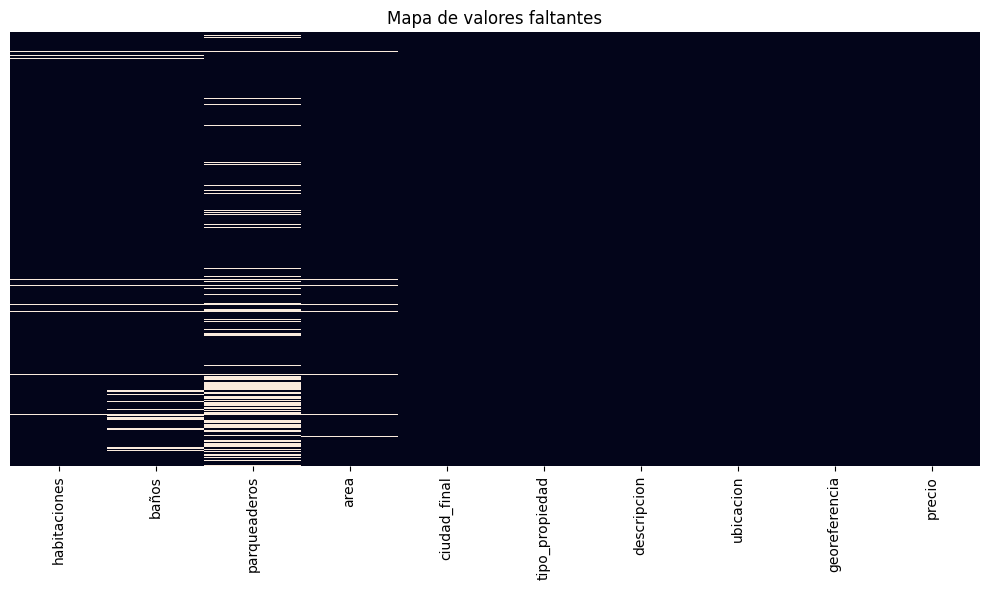

In [17]:
# Visualizar datos faltantes
plt.figure(figsize=(10, 6))
sns.heatmap(data[num_cols + cat_cols + [target]].isnull(), cbar=False, yticklabels=False)
plt.title('Mapa de valores faltantes')
plt.tight_layout()

In [18]:
# Data frame completo mostrando todas las columnas pero donde hay valores faltantes
data[data.isnull().any(axis=1)]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
3,194000000,"loma del atravesado, palmas, mesa",3.0,1.0,NaN,78.0,encantadora casa cuenta servicios completos in...,Casa en venta,vereda planta,medellin,2.487179e+06
5,170000000,"boston, buenos aires, miraflores",3.0,2.0,NaN,75.0,casa 2 pisos independientes espacios grandes a...,Casa en venta,trece noviembre,medellin,2.266667e+06
21,4500000000,"finca a venta, sector don diego palomino, cato...",NaN,NaN,NaN,NaN,,Finca en venta,bonda sector macinga,desconocida,NaN
25,300000000,"santo tomas, guarne, centro",NaN,NaN,0.0,2957.0,bienvenido aguaclara oasis tranquilidad hermos...,Lote en venta,pastorcita,pasto,1.014542e+05
28,2400000,"ditaires, santa catalina, ferreria",NaN,NaN,0.0,29.0,posiciona negocio local 2860 m ubicado prestig...,Local Comercial en arriendo o venta,san andres,medellin,8.275862e+04
...,...,...,...,...,...,...,...,...,...,...,...
467,15000000,"nicolas de federman, porciuncula, polo club",5.0,0.0,NaN,615.0,oportunidad única barrio san miguel descubre e...,Bodega en arriendo,siete agosto,bogota,2.439024e+04
469,14000000,"laureles, rosales, acacias",5.0,0.0,NaN,720.0,bodega ubicada cuarto piso sector comercial bu...,Bodega en arriendo,laureles,desconocida,1.944444e+04
472,16500000,"castropol, simesa, san diego",5.0,0.0,NaN,460.0,arriendo bodega barrio colombia primer piso 46...,Bodega en arriendo,colombia,bogota,3.586957e+04
474,15000000,"tintal a.s.d., predio caldas, morabia",5.0,0.0,NaN,432.0,arriendo magnifica bodega comercial 432 excele...,Bodega en arriendo,fontibon,bogota,3.472222e+04


In [19]:
data[data.isnull().sum(axis=1) > 3]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
21,4500000000,"finca a venta, sector don diego palomino, cato...",NaN,NaN,NaN,NaN,,Finca en venta,bonda sector macinga,desconocida,NaN
272,10000000011,te presentamos esta finca ubicado en direccion...,NaN,NaN,NaN,NaN,,Finca en venta,santuario,desconocida,NaN
279,488488000,te presentamos confortable casa ubicada en sec...,NaN,NaN,NaN,NaN,,Casa en venta,pontevedra,desconocida,NaN
300,669000002115975,te presentamos esta confortable casa ubicada e...,NaN,NaN,NaN,NaN,,Casa en venta,san cayetano,desconocida,NaN
308,208200000321879,te presentamos confortable apartamento ubicado...,NaN,NaN,NaN,NaN,,Apartamento en venta,tena,bogota,NaN
377,1500000000,te presentamos esta confortable casa campestre...,NaN,NaN,NaN,NaN,,Casa campestre en venta,otros,medellin,NaN
422,3750000034121000,bodega industrial en dorado area de 1.950 metr...,NaN,NaN,NaN,NaN,,Bodega en arriendo,dorado,medellin,NaN


Entre mas datos faltantes tenga un dato menos util es y la posibilidad de que sea un dato erroneo aumentan

In [20]:
# Busquemos datos que digan lote en la descripcion o en el tipo de propiedad
data[(data['descripcion'].str.contains('lote', case=False, na=False) | data['tipo_propiedad'].str.contains('lote', case=False, na=False)) & data.isnull().any(axis=1)]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
25,300000000,"santo tomas, guarne, centro",NaN,NaN,0.0,2957.0,bienvenido aguaclara oasis tranquilidad hermos...,Lote en venta,pastorcita,pasto,101454.176530
196,2500000,"salado, br modelia . i, ibague",5.0,3.0,NaN,270.0,casa nueva 10 10 lote esquinera primer piso do...,Casa en arriendo o venta,ceibita,ibague,9259.259259
426,9900000,"santa barbara occidental, cedritos, contador",3.0,NaN,0.0,300.0,bodega construida licencia trifasica buena luz...,Bodega en arriendo,prado veraniego,bogota,33000.000000
429,3200000,"santa monica, granada, prados del",3.0,0.0,NaN,302.0,alquila bodega barrio san nicolás uso suelo mi...,Bodega en arriendo,san nicolas,desconocida,10596.026490


Los lotes no tienen parqueaderos, baños ni habitaciones por que cuando un tipo de propiedad sea lote los valores faltantes de habitaciones, baños y parqueaderos van ser 0


In [21]:
# 1) Imputar los valores faltantes de habitaciones, baños y parqueaderos con 0
data.loc[data['tipo_propiedad'] == 'Lote en venta', ['habitaciones', 'baños', 'parqueaderos']] = 0


In [22]:
# Veamos mas datos en donde habitaciones, baños y parqueaderos son nulos
data[(data['habitaciones'].isnull() | data['baños'].isnull() | data['parqueaderos'].isnull()) & data.isnull().any(axis=1)]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
3,194000000,"loma del atravesado, palmas, mesa",3.0,1.0,NaN,78.0,encantadora casa cuenta servicios completos in...,Casa en venta,vereda planta,medellin,2.487179e+06
5,170000000,"boston, buenos aires, miraflores",3.0,2.0,NaN,75.0,casa 2 pisos independientes espacios grandes a...,Casa en venta,trece noviembre,medellin,2.266667e+06
21,4500000000,"finca a venta, sector don diego palomino, cato...",NaN,NaN,NaN,NaN,,Finca en venta,bonda sector macinga,desconocida,NaN
28,2400000,"ditaires, santa catalina, ferreria",NaN,NaN,0.0,29.0,posiciona negocio local 2860 m ubicado prestig...,Local Comercial en arriendo o venta,san andres,medellin,8.275862e+04
73,1350000,"ferreria, san antonio de prado, prado",3.0,2.0,NaN,44.0,,Apartamento en arriendo,san antonio prado,medellin,3.068182e+04
...,...,...,...,...,...,...,...,...,...,...,...
467,15000000,"nicolas de federman, porciuncula, polo club",5.0,0.0,NaN,615.0,oportunidad única barrio san miguel descubre e...,Bodega en arriendo,siete agosto,bogota,2.439024e+04
469,14000000,"laureles, rosales, acacias",5.0,0.0,NaN,720.0,bodega ubicada cuarto piso sector comercial bu...,Bodega en arriendo,laureles,desconocida,1.944444e+04
472,16500000,"castropol, simesa, san diego",5.0,0.0,NaN,460.0,arriendo bodega barrio colombia primer piso 46...,Bodega en arriendo,colombia,bogota,3.586957e+04
474,15000000,"tintal a.s.d., predio caldas, morabia",5.0,0.0,NaN,432.0,arriendo magnifica bodega comercial 432 excele...,Bodega en arriendo,fontibon,bogota,3.472222e+04


Filtrando por los datos que tienen datos faltantes buscamos la palabra "parquea" dentro de las columnas de descripcion y ubicacion

In [23]:
data[
    (data['descripcion'].str.contains('parquea', case=False, na=False) | 
     data['ubicacion'].str.contains('parquea', case=False, na=False)) & 
    data['parqueaderos'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
212,3000000,"santa rosa de lima, colores, estadio",6.0,3.0,NaN,180.0,espectacular casa arriendo ubicado barrio cala...,Casa en arriendo,manrique,medellin,16666.666667
450,50875000,"simon bolivar sb (centro), guasimalito, azulita",4.0,0.0,NaN,2034.0,bodega arriendo bello parque empresarial norti...,Bodega en arriendo,villas copacabana,medellin,25012.291052
456,9000000,"alejandria, patio bonito, santa maria de angeles",4.0,3.0,NaN,280.0,bodega arriendo cerca estacion metro supermerc...,Bodega en arriendo,guayabal,desconocida,32142.857143
466,27900000,"candelaria, medellin, villanueva",5.0,2.0,NaN,500.0,bodega chagualo 500 excelente opcion empresas ...,Bodega en arriendo,chagualo,medellin,55800.000000


In [24]:
data[
    (data['descripcion'].str.contains(r'\b(parquea|parqueadero|parqueo|estacionamiento|aparca|aparcamiento|parking|garaje)\b', case=False, na=False)| 
     data['ubicacion'].str.contains(r'\b(parquea|parqueadero|parqueo|estacionamiento|aparca|aparcamiento|parking|garaje)\b', case=False, na=False)) & 
    data['parqueaderos'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
289,65000000,"santa teresita, bellavista, normandia",2.0,2.0,NaN,59.75,presentamos confortable casa ubicada san cayet...,Casa en venta,san cayetano,desconocida,1.087866e+06
294,190000000,"centro, fusagasuga, paseo real",2.0,2.0,NaN,50.93,presentamos confortable apartamento ubicado ba...,Apartamento en venta,cr san martin olivos,desconocida,3.730611e+06
300,669000002115975,te presentamos esta confortable casa ubicada e...,NaN,NaN,NaN,NaN,,Casa en venta,san cayetano,desconocida,NaN
306,366000000,"cajica , misterio, vda canelon",3.0,2.0,NaN,99.00,presentamos confortable casa ubicada sector ca...,Casa en venta,centro,medellin,3.696970e+06
308,208200000321879,te presentamos confortable apartamento ubicado...,NaN,NaN,NaN,NaN,,Apartamento en venta,tena,bogota,NaN
315,256000000,"obrero, angeles, mayales i",3.0,2.0,NaN,74.77,presentamos confortable apartamento ubicado se...,Apartamento en venta,villa alicia,desconocida,3.423833e+06
319,92500000,"mt cerro campestre alto, vereda samaria",3.0,1.0,NaN,75.00,presentamos confortable casa ubicada sector ba...,Casa en venta,antioquia,medellin,1.233333e+06
367,303000000,"ingles, providencia, olaya",6.0,4.0,NaN,217.94,presentamos confortable casa ubicada sector gr...,Casa en venta,granjas san pablo,desconocida,1.390291e+06
382,2400000,"candelaria, medellin, boston",1.0,0.0,NaN,74.00,bodega arrendar centro ubicada avenida echever...,Bodega en arriendo,candelaria,medellin,3.243243e+04
412,7500000,"entre amigos, centro, dorado",2.0,0.0,NaN,300.00,gran oportunidad moderna bodega industrial ópt...,Bodega en arriendo,prados sabaneta,medellin,2.500000e+04


In [25]:
data[
    (data['descripcion'].str.contains('baño', case=False, na=False) | 
     data['ubicacion'].str.contains('baño', case=False, na=False)) & 
    data['baños'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
426,9900000,"santa barbara occidental, cedritos, contador",3.0,NaN,0.0,300.0,bodega construida licencia trifasica buena luz...,Bodega en arriendo,prado veraniego,bogota,33000.0


In [26]:
data[
    (data['descripcion'].str.contains(r'\b(baño|sanitario|bañera|bano)\b', case=False, na=False) | 
     data['ubicacion'].str.contains(r'\b(baño|sanitario|bañera|bano)\b', case=False, na=False)) & 
    data['baños'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
279,488488000,te presentamos confortable casa ubicada en sec...,NaN,NaN,NaN,NaN,,Casa en venta,pontevedra,desconocida,NaN
300,669000002115975,te presentamos esta confortable casa ubicada e...,NaN,NaN,NaN,NaN,,Casa en venta,san cayetano,desconocida,NaN
396,2000000,"tintal a.s.d., predio caldas, morabia",1.0,NaN,0.0,80.0,espectacular bodega ubicada sector fontibon bo...,Bodega en arriendo,fontibon centro,bogota,25000.0
426,9900000,"santa barbara occidental, cedritos, contador",3.0,NaN,0.0,300.0,bodega construida licencia trifasica buena luz...,Bodega en arriendo,prado veraniego,bogota,33000.0


In [27]:
data[
    (data['descripcion'].str.contains(r'\b(habita|habitaciones|alcobas|alcoba|habitacion)\b', case=False, na=False)| 
     data['ubicacion'].str.contains(r'\b(habita|habitaciones|alcobas|alcoba|habitacion)\b', case=False, na=False)) & 
    data['habitaciones'].isnull()
]

,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
300,669000002115975,te presentamos esta confortable casa ubicada e...,NaN,NaN,NaN,NaN,,Casa en venta,san cayetano,desconocida,NaN
308,208200000321879,te presentamos confortable apartamento ubicado...,NaN,NaN,NaN,NaN,,Apartamento en venta,tena,bogota,NaN


In [28]:
data[
    (data['descripcion'].str.contains(r'\b(metro|metros|area|tamaño)\b', case=False, na=False) | 
     data['ubicacion'].str.contains(r'\b(metro|metros|area|tamaño)\b', case=False, na=False)) & 
    data['area'].isnull()
]


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2
272,10000000011,te presentamos esta finca ubicado en direccion...,NaN,NaN,NaN,NaN,,Finca en venta,santuario,desconocida,NaN
279,488488000,te presentamos confortable casa ubicada en sec...,NaN,NaN,NaN,NaN,,Casa en venta,pontevedra,desconocida,NaN
377,1500000000,te presentamos esta confortable casa campestre...,NaN,NaN,NaN,NaN,,Casa campestre en venta,otros,medellin,NaN
422,3750000034121000,bodega industrial en dorado area de 1.950 metr...,NaN,NaN,NaN,NaN,,Bodega en arriendo,dorado,medellin,NaN
446,8000000,"alejandria, patio bonito, aguacatala",4.0,2.0,1.0,NaN,codigo 44710308 bodegaarriendoguayabal ubicaci...,Bodega en arriendo,cristo rey,desconocida,NaN


Esta es una primera version de la función que va a encontrar la información faltante, solo usa keywords para encontrarlas pero como notaron anteriormente usar expresiones regulares suele encontrar mejores resultados

In [29]:
import re
import pandas as pd

def extract_missing_info(df):
    """
    Extract missing information from description and location fields.
    
    Args:
        df (pandas.DataFrame): The dataframe with missing values
        
    Returns:
        pandas.DataFrame: The dataframe with imputed values
    """
    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Function to extract numbers from text
    def extract_numbers(text):
        if not isinstance(text, str):
            return []
        # Find all numbers (including decimals)
        return re.findall(r'\b\d+(?:\.\d+)?\b', text)
    
    # Function to extract number preceding or following specific keywords
    def extract_number_near_keyword(text, keywords, default=1):
        if not isinstance(text, str):
            return None
        
        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()
        
        # Look for patterns like "X keyword" or "keyword X"
        for keyword in keywords:
            # Pattern for "X keyword" (e.g., "2 habitaciones")
            pattern1 = r'(\d+)\s+' + re.escape(keyword)
            match1 = re.search(pattern1, text_lower)
            if match1:
                return float(match1.group(1))
            
            # Pattern for "keyword X" (e.g., "habitaciones 2")
            pattern2 = re.escape(keyword) + r'\s+(\d+)'
            match2 = re.search(pattern2, text_lower)
            if match2:
                return float(match2.group(1))
            
            # Check if keyword exists without a number
            if keyword in text_lower:
                return default
        
        return None
    
    # 1. Extract habitaciones (rooms)
    habitacion_keywords = ['habitacion', 'habitaciones', 'alcoba', 'alcobas', 'cuarto', 'cuartos', 'dormitorio', 'dormitorios']
    
    # Apply to rows where habitaciones is null
    for idx in df_copy[df_copy['habitaciones'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Try to extract room count
        room_count = extract_number_near_keyword(combined_text, habitacion_keywords)
        if room_count is not None:
            df_copy.loc[idx, 'habitaciones'] = room_count
    #r'\b(baño|sanitario|bañera|bano)\b'
    # 2. Extract baños (bathrooms)
    bano_keywords = ['baño', 'baños', 'sanitario', 'sanitarios', 'wc', 'bano','bañera', 'bañeras']
    
    # Apply to rows where baños is null
    for idx in df_copy[df_copy['baños'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Try to extract bathroom count
        bathroom_count = extract_number_near_keyword(combined_text, bano_keywords)
        if bathroom_count is not None:
            df_copy.loc[idx, 'baños'] = bathroom_count
    #r'\b(parquea|parqueadero|parqueo|estacionamiento|aparca|aparcamiento|parking|garaje)\b'
    # 3. Extract parqueaderos (parking spaces)
    parking_keywords = ['parqueadero', 'parqueaderos', 'estacionamiento', 'estacionamientos', 
                        'garaje', 'garajes', 'parking', 'cochera', 'cocheras', 'aparca', 'aparcamientos']
    
    # Apply to rows where parqueaderos is null
    for idx in df_copy[df_copy['parqueaderos'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Try to extract parking count
        parking_count = extract_number_near_keyword(combined_text, parking_keywords)
        if parking_count is not None:
            df_copy.loc[idx, 'parqueaderos'] = parking_count
    
    # 4. Extract area
    area_keywords = ['metro', 'metros', 'area', 'área', 'tamaño', 'm2', 'mts', 'mt2']
    
    # Apply to rows where area is null
    for idx in df_copy[df_copy['area'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Looking for area patterns is more complex - try to extract numbers near area keywords
        for keyword in area_keywords:
            # Pattern for "X keyword" (e.g., "250 metros")
            pattern = r'(\d+(?:\.\d+)?)\s*' + re.escape(keyword)
            match = re.search(pattern, combined_text.lower())
            if match:
                df_copy.loc[idx, 'area'] = float(match.group(1))
                break
        
        # If area is still null but a keyword is found, set default area
        if pd.isna(df_copy.loc[idx, 'area']):
            for keyword in area_keywords:
                if keyword in combined_text.lower():
                    df_copy.loc[idx, 'area'] = 1  # Default area value
                    break

        if pd.isna(df_copy.loc[idx, 'habitaciones']):
            for keyboard in habitacion_keywords:
                if keyword in combined_text.lower():
                    df_copy.loc[idx, 'habitaciones'] = 1
                    break

        if pd.isna(df_copy.loc[idx, 'habitaciones']):
            for keyboard in habitacion_keywords:
                if keyword in combined_text.lower():
                    df_copy.loc[idx, 'habitaciones'] = 1
                    break
    
    # 5. Special case for Lotes (if not already handled)
    df_copy.loc[df_copy['tipo_propiedad'].str.contains('lote', case=False, na=False) & 
                df_copy[['habitaciones', 'baños', 'parqueaderos']].isnull().any(axis=1), 
                ['habitaciones', 'baños', 'parqueaderos']] = 0
    
    return df_copy

In [30]:
import re
import pandas as pd

def extract_missing_habitaciones(df):
    """
    Imputa la columna 'habitaciones' usando:
      1) extracción de número cerca de palabras clave de habitaciones,
      2) si sigue nulo y aparece una keyword de habitaciones → 1
      3) si sigue nulo y aparece una keyword de área → 1 
    """
    df_copy = df.copy()

    # 1) Keywords de habitaciones y área
    habit_keywords = [
        'habitacion','habitaciones','alcoba','alcobas',
        'cuarto','cuartos','dormitorio','dormitorios'
    ]

    # Helper para texto completo
    def full_text(row):
        desc = row.get('descripcion') or ""
        ubi  = row.get('ubicacion')  or ""
        return f"{desc} {ubi}".lower()

    # 2) Función que busca número antes o después de la keyword
    def extract_number_near_keyword(text, keywords, default=1):
        for kw in keywords:
            # patrón "X kw"
            m = re.search(r'(\d+)\s+' + re.escape(kw), text)
            if m:
                return float(m.group(1))
            # patrón "kw X"
            m = re.search(re.escape(kw) + r'\s+(\d+)', text)
            if m:
                return float(m.group(1))
            # fallback si aparece la palabra
            if kw in text:
                return float(default)
        return None

    # 3) Primera pasada: extraer número o fallback=1 si hay keyword de habitaciones
    for idx in df_copy[df_copy['habitaciones'].isnull()].index:
        txt = full_text(df_copy.loc[idx])
        val = extract_number_near_keyword(txt, habit_keywords, default=1)
        if val is not None:
            df_copy.at[idx, 'habitaciones'] = val


    return df_copy


In [31]:
import re
import pandas as pd

def extract_missing_info(df):
    """
    Extract missing information from description and location fields.
    
    Args:
        df (pandas.DataFrame): The dataframe with missing values
        
    Returns:
        pandas.DataFrame: The dataframe with imputed values
    """
    # Create a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Function to extract number preceding or following specific keywords
    def extract_number_near_keyword(text, keywords, default=1):
        if not isinstance(text, str):
            return None
        
        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()
        
        # Look for patterns like "X keyword" or "keyword X"
        for keyword in keywords:
            # Pattern for "X keyword" (e.g., "2 habitaciones")
            pattern1 = r'(\d+)\s+' + re.escape(keyword)
            match1 = re.search(pattern1, text_lower)
            if match1:
                return float(match1.group(1))
            
            # Pattern for "keyword X" (e.g., "habitaciones 2")
            pattern2 = re.escape(keyword) + r'\s+(\d+)'
            match2 = re.search(pattern2, text_lower)
            if match2:
                return float(match2.group(1))
            
            # Check if keyword exists without a number
            if keyword in text_lower:
                return default
        
        return None
    
    # Function to extract number preceding or following specific regex pattern
    def extract_number_near_pattern(text, pattern, default=1):
        if not isinstance(text, str):
            return None
        
        # Convert text to lowercase for case-insensitive matching
        text_lower = text.lower()
        
        # Pattern for "X keyword" (e.g., "2 baños")
        pattern_before = r'(\d+(?:\.\d+)?)\s*(?:' + pattern + r')'
        match_before = re.search(pattern_before, text_lower)
        if match_before:
            return float(match_before.group(1))
        
        # Pattern for "keyword X" (e.g., "baños 2")
        pattern_after = r'(?:' + pattern + r')\s*(\d+(?:\.\d+)?)'
        match_after = re.search(pattern_after, text_lower)
        if match_after:
            return float(match_after.group(1))
        
        # Check if keyword exists without a number
        if re.search(pattern, text_lower):
            return default
        
        return None
    
    # Define keywords and patterns for each category
    # Using the original keywords for habitaciones
    habitacion_keywords = ['habitacion', 'habitaciones', 'alcoba', 'alcobas', 'cuarto', 'cuartos', 'dormitorio', 'dormitorios']
    
    # Extended habitacion keywords 
    extended_habitacion_keywords = ['recamara', 'recamaras', 'pieza', 'piezas', 'bedroom', 'bedrooms', 
                                   'hab', 'habs', 'alcoba', 'alcobas']
    
    # Improved pattern for baños 
    bano_pattern = r'ba(?:ñ|n)o(?:s)?|sanitario(?:s)?|wc|lavabo(?:s)?|toilet(?:s)?|aseo(?:s)?|ducha(?:s)?'
    
    # Original keywords for baños 
    bano_keywords = ['baño', 'baños', 'sanitario', 'sanitarios', 'wc', 'bano', 'bañera', 'bañeras']
    
    # Improved pattern for parqueaderos 
    parking_pattern = r'parque(?:adero)?(?:s)?|parqueo(?:s)?|estacionamiento(?:s)?|garaj(?:e(?:s)?)?|parking(?:s)?|cocher(?:a(?:s)?)?|aparca(?:miento)?(?:s)?|plaza(?:s)?\s*(?:de\s*)?(?:aparcamiento|garaje|parking)?'
    
    # Original keywords for parqueaderos 
    parking_keywords = ['parqueadero', 'parqueaderos', 'estacionamiento', 'estacionamientos', 
                        'garaje', 'garajes', 'parking', 'cochera', 'cocheras', 'aparca', 'aparcamientos']
    
    # Original keywords for area
    area_keywords = ['metro', 'metros', 'area', 'área', 'tamaño', 'm2', 'mts', 'mt2']
    

    # 1. Extract habitaciones (rooms) 
    for idx in df_copy[df_copy['habitaciones'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        room_count = extract_number_near_keyword(combined_text, habitacion_keywords)
        if room_count is not None:
            df_copy.loc[idx, 'habitaciones'] = room_count
            continue  # If found, move to next record
        
        
        if pd.isna(df_copy.loc[idx, 'habitaciones']):  # If still null
            room_count = extract_number_near_keyword(combined_text, extended_habitacion_keywords)
            if room_count is not None:
                df_copy.loc[idx, 'habitaciones'] = room_count
                continue  # If found, move to next record
        
       
        if pd.isna(df_copy.loc[idx, 'habitaciones']):  # If still null
            # Check for patterns like "1-room", "1 room", etc.
            room_patterns = [
                r'(\d+)\s*-?\s*(?:room|bedroom|hab|habitacion)',
                r'(?:de|con)\s+(\d+)\s+(?:habitacion|dormitorio|alcoba|cuarto)',
                r'(\d+)\s+(?:habitacion|dormitorio|alcoba|cuarto)'
            ]
            
            for pattern in room_patterns:
                match = re.search(pattern, combined_text.lower())
                if match:
                    df_copy.loc[idx, 'habitaciones'] = float(match.group(1))
                    break
                
        # Last resort - property type hints
        if pd.isna(df_copy.loc[idx, 'habitaciones']):  # If still null
            property_type = str(df_copy.loc[idx, 'tipo_propiedad']).lower() if not pd.isna(df_copy.loc[idx, 'tipo_propiedad']) else ""
            if "apartaestudio" in property_type or "estudio" in property_type:
                df_copy.loc[idx, 'habitaciones'] = 1  # Studios typically have 1 room
    
    # 2. Extract baños (bathrooms) 
    for idx in df_copy[df_copy['baños'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # First try the original method 
        bathroom_count = extract_number_near_keyword(combined_text, bano_keywords)
        if bathroom_count is not None:
            df_copy.loc[idx, 'baños'] = bathroom_count
            continue  # If found, move to next record
        
        # Then try the pattern method
        if pd.isna(df_copy.loc[idx, 'baños']):  # If still null
            bathroom_count = extract_number_near_pattern(combined_text, bano_pattern)
            if bathroom_count is not None:
                df_copy.loc[idx, 'baños'] = bathroom_count
                continue
        
        # Special case for bathrooms
        if pd.isna(df_copy.loc[idx, 'baños']):  # If still null
            if "un baño" in combined_text.lower() or "un bano" in combined_text.lower():
                df_copy.loc[idx, 'baños'] = 1
    
    # 3. Extract parqueaderos (parking spaces) 
    for idx in df_copy[df_copy['parqueaderos'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # First try the pattern method 
        parking_count = extract_number_near_pattern(combined_text, parking_pattern)
        if parking_count is not None:
            df_copy.loc[idx, 'parqueaderos'] = parking_count
            continue
        
        # Then try the original method 
        if pd.isna(df_copy.loc[idx, 'parqueaderos']):  # If still null
            parking_count = extract_number_near_keyword(combined_text, parking_keywords)
            if parking_count is not None:
                df_copy.loc[idx, 'parqueaderos'] = parking_count
                continue
        
        # Special case for parking
        if pd.isna(df_copy.loc[idx, 'parqueaderos']):  # If still null
            if "un parqueadero" in combined_text.lower() or "un garaje" in combined_text.lower():
                df_copy.loc[idx, 'parqueaderos'] = 1
    
    # 4. Extract area 
    for idx in df_copy[df_copy['area'].isnull()].index:
        desc_text = str(df_copy.loc[idx, 'descripcion']) if not pd.isna(df_copy.loc[idx, 'descripcion']) else ""
        ubic_text = str(df_copy.loc[idx, 'ubicacion']) if not pd.isna(df_copy.loc[idx, 'ubicacion']) else ""
        combined_text = desc_text + " " + ubic_text
        
        # Looking for area patterns is more complex - try to extract numbers near area keywords
        for keyword in area_keywords:
            # Pattern for "X keyword" (e.g., "250 metros")
            pattern = r'(\d+(?:\.\d+)?)\s*' + re.escape(keyword)
            match = re.search(pattern, combined_text.lower())
            if match:
                df_copy.loc[idx, 'area'] = float(match.group(1))
                break
            
            # Additional pattern for "keyword: X" (e.g., "area: 250")
            pattern2 = re.escape(keyword) + r':\s*(\d+(?:\.\d+)?)'
            match2 = re.search(pattern2, combined_text.lower())
            if match2:
                df_copy.loc[idx, 'area'] = float(match2.group(1))
                break

        """
        # If area is still null but a keyword is found, set default area
        if pd.isna(df_copy.loc[idx, 'area']):
            for keyword in area_keywords:
                if keyword in combined_text.lower():
                    df_copy.loc[idx, 'area'] = 1  # Default area value
                    break
        """
    # 5. Special case for Lotes (if not already handled)
    df_copy.loc[df_copy['tipo_propiedad'].str.contains('lote', case=False, na=False) & 
                df_copy[['habitaciones', 'baños', 'parqueaderos']].isnull().any(axis=1), 
                ['habitaciones', 'baños', 'parqueaderos']] = 0
    
    """    
    # 6. Fix common mistakes: negative values or unrealistically high values
    # For rooms, bathrooms, and parking spaces, cap at reasonable maximums
    df_copy['habitaciones'] = df_copy['habitaciones'].apply(
        lambda x: max(0, min(x, 20)) if not pd.isna(x) else x
    )
    df_copy['baños'] = df_copy['baños'].apply(
        lambda x: max(0, min(x, 15)) if not pd.isna(x) else x
    )
    df_copy['parqueaderos'] = df_copy['parqueaderos'].apply(
        lambda x: max(0, min(x, 10)) if not pd.isna(x) else x
    )
    # Tambien lo hago para tener datos que puedan representar a la mayoria"""
    return df_copy

In [32]:

data_imputed_habitaciones = extract_missing_habitaciones(data)
# Check how many values were imputed
for col in ['habitaciones', 'baños', 'parqueaderos', 'area']:
    original_nulls = data[col].isnull().sum()
    new_nulls = data_imputed_habitaciones[col].isnull().sum()
    print(f"{col}: {original_nulls - new_nulls} values imputed ({original_nulls} → {new_nulls} missing)")

habitaciones: 2 values imputed (8 → 6 missing)
baños: 0 values imputed (24 → 24 missing)
parqueaderos: 0 values imputed (98 → 98 missing)
area: 0 values imputed (8 → 8 missing)


In [33]:

data_imputed = extract_missing_info(data_imputed_habitaciones)
# Check how many values were imputed
for col in ['habitaciones', 'baños', 'parqueaderos', 'area']:
    original_nulls = data_imputed_habitaciones[col].isnull().sum()
    new_nulls = data_imputed[col].isnull().sum()
    print(f"{col}: {original_nulls - new_nulls} values imputed ({original_nulls} → {new_nulls} missing)")

habitaciones: 0 values imputed (6 → 6 missing)
baños: 6 values imputed (24 → 18 missing)
parqueaderos: 36 values imputed (98 → 62 missing)
area: 5 values imputed (8 → 3 missing)


In [34]:
# Exportar el dataframe limpio
#data_imputed.to_csv('propiedades_limpias_FINAL.csv', index=False, encoding='utf-8-sig')

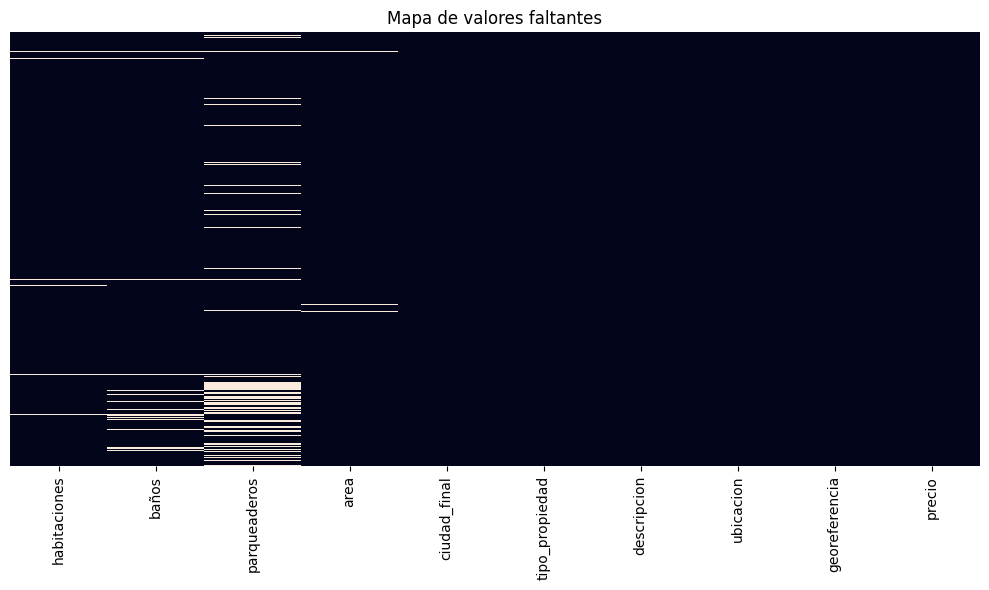

In [35]:
plt.figure(figsize=(10, 6))
sns.heatmap(data_imputed[num_cols + cat_cols + [target]].isnull(), cbar=False, yticklabels=False)
plt.title('Mapa de valores faltantes')
plt.tight_layout()

KNN imputer o *IterativeImputer* de Scikit-learn para imputer valores faltantes en columnas numericas pero hay que tener cuidado al hacer esto debido a que la imputacion no tiene en cuenta el contexto de las columnas por lo que nosostros somos responsables de pulirlo

In [36]:

# Usin KNNImputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='uniform')
data_imputed_knn = data_imputed.copy()
data_imputed_knn[num_cols] = imputer.fit_transform(data_imputed_knn[num_cols])


# Check how many values were imputed
for col in num_cols:
    original_nulls = data_imputed[col].isnull().sum()
    new_nulls = data_imputed_knn[col].isnull().sum()
    print(f"{col}: {original_nulls - new_nulls} values imputed ({original_nulls} → {new_nulls} missing)")

# Identify rows where values were imputed
imputed_rows = data_imputed[num_cols].isnull() & ~data_imputed_knn[num_cols].isnull()

# Create a DataFrame to show the original and imputed values
imputed_data = data_imputed.loc[imputed_rows.any(axis=1), num_cols].copy()
imputed_data['imputed'] = True  # Add a flag to indicate these rows were imputed

# Display the imputed data
print("Rows with imputed values:")
print(imputed_data)

# Optionally, compare original and imputed values side by side
comparison = pd.concat(
    [data_imputed.loc[imputed_rows.any(axis=1), num_cols], 
     data_imputed_knn.loc[imputed_rows.any(axis=1), num_cols]],
    keys=['Original', 'Imputed'],
    axis=1
)

print("\nComparison of original and imputed values:")
print(comparison)

habitaciones: 6 values imputed (6 → 0 missing)
baños: 18 values imputed (18 → 0 missing)
parqueaderos: 62 values imputed (62 → 0 missing)
area: 3 values imputed (3 → 0 missing)
Rows with imputed values:
     habitaciones  baños  parqueaderos    area  imputed
3             3.0    1.0           NaN    78.0     True
5             3.0    2.0           NaN    75.0     True
21            NaN    NaN           NaN     NaN     True
28            NaN    NaN           0.0    29.0     True
73            3.0    2.0           NaN    44.0     True
..            ...    ...           ...     ...      ...
467           5.0    0.0           NaN   615.0     True
469           5.0    0.0           NaN   720.0     True
472           5.0    0.0           NaN   460.0     True
474           5.0    0.0           NaN   432.0     True
478           5.0    5.0           NaN  3000.0     True

[80 rows x 5 columns]

Comparison of original and imputed values:
        Original                                 Imputed  

In [37]:
imputer = KNNImputer(n_neighbors=5, weights='uniform')
data_imputed_knn = data_imputed.copy()
data_imputed_knn[num_cols] = imputer.fit_transform(data_imputed_knn[num_cols])

# Cast specific columns to integer type after imputation
integer_cols = ['habitaciones', 'baños', 'parqueaderos']
data_imputed_knn[integer_cols] = data_imputed_knn[integer_cols].round().astype(int)

# Check how many values were imputed
for col in num_cols:
    original_nulls = data_imputed[col].isnull().sum()
    new_nulls = data_imputed_knn[col].isnull().sum()
    print(f"{col}: {original_nulls - new_nulls} values imputed ({original_nulls} → {new_nulls} missing)")


# Identify rows where values were imputed (using the original nulls for accuracy)
imputed_rows = data_imputed[num_cols].isnull()

# Create a DataFrame to show the original and imputed values
imputed_data = data_imputed.loc[imputed_rows.any(axis=1), num_cols].copy()
imputed_data['imputed'] = data_imputed_knn.loc[imputed_rows.any(axis=1), integer_cols].notna().any(axis=1) # Flag if any of the integer cols were imputed

# Display the imputed data
print("\nRows with imputed values (before integer casting):")
print(data_imputed.loc[imputed_rows.any(axis=1), num_cols])
print("\nRows with imputed values (after integer casting):")
print(data_imputed_knn.loc[imputed_rows.any(axis=1), num_cols])

# Optionally, compare original and imputed values side by side
comparison = pd.concat(
    [data.loc[imputed_rows.any(axis=1), num_cols],
     data_imputed_knn.loc[imputed_rows.any(axis=1), num_cols]],
    keys=['Original', 'Imputed'],
    axis=1
)

print("\nComparison of original and imputed values:")
print(comparison)

habitaciones: 6 values imputed (6 → 0 missing)
baños: 18 values imputed (18 → 0 missing)
parqueaderos: 62 values imputed (62 → 0 missing)
area: 3 values imputed (3 → 0 missing)

Rows with imputed values (before integer casting):
     habitaciones  baños  parqueaderos    area
3             3.0    1.0           NaN    78.0
5             3.0    2.0           NaN    75.0
21            NaN    NaN           NaN     NaN
28            NaN    NaN           0.0    29.0
73            3.0    2.0           NaN    44.0
..            ...    ...           ...     ...
467           5.0    0.0           NaN   615.0
469           5.0    0.0           NaN   720.0
472           5.0    0.0           NaN   460.0
474           5.0    0.0           NaN   432.0
478           5.0    5.0           NaN  3000.0

[80 rows x 4 columns]

Rows with imputed values (after integer casting):
     habitaciones  baños  parqueaderos        area
3               3      1             1    78.00000
5               3      2       

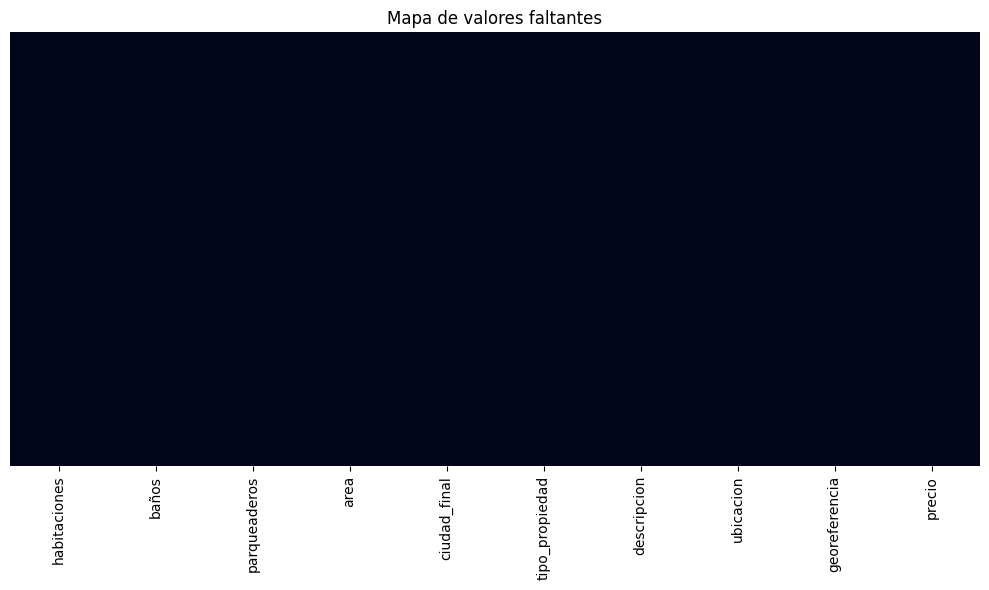

In [38]:
# Eliminar filas con más de 3 valores faltantes
#data_imputed = data_imputed.dropna(thresh=len(data_imputed.columns) - 3)
plt.figure(figsize=(10, 6))
sns.heatmap(data_imputed_knn[num_cols + cat_cols + [target]].isnull(), cbar=False, yticklabels=False)
plt.title('Mapa de valores faltantes')
plt.tight_layout()

La variable descripcion se encuentra normalizada por el proceso anterior, por lo que ahora solo nos queda hacer una tokenizacion <br>
Convertir un conjunto de textos (“descripciones” de propiedades) en una representación numérica (una matriz) que capture la importancia relativa de cada palabra en cada documento, de modo que pueda usarse directamente como entrada a modelos de machine learning (regresores, clasificadores, etc.).




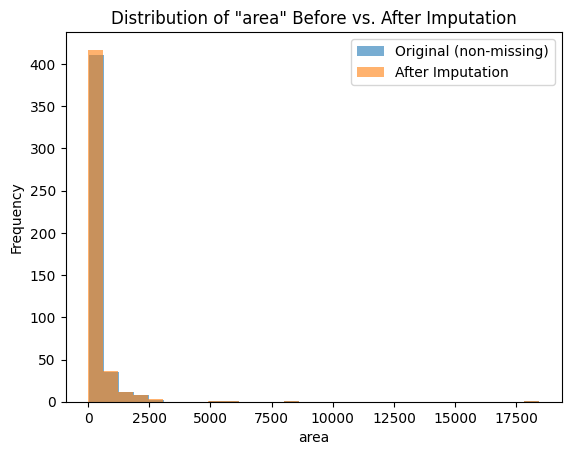

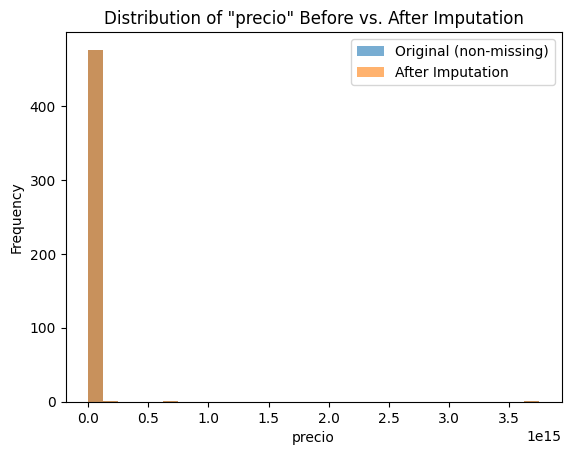

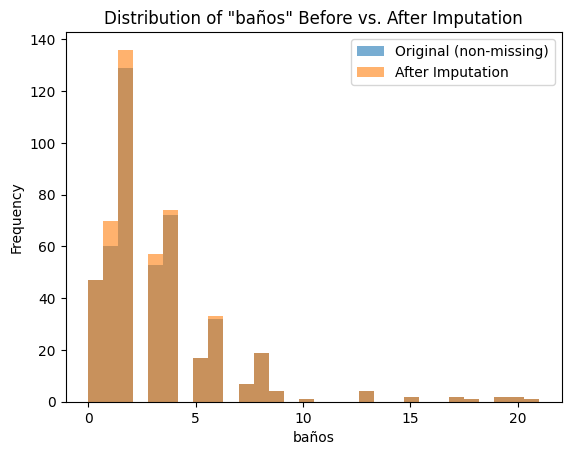

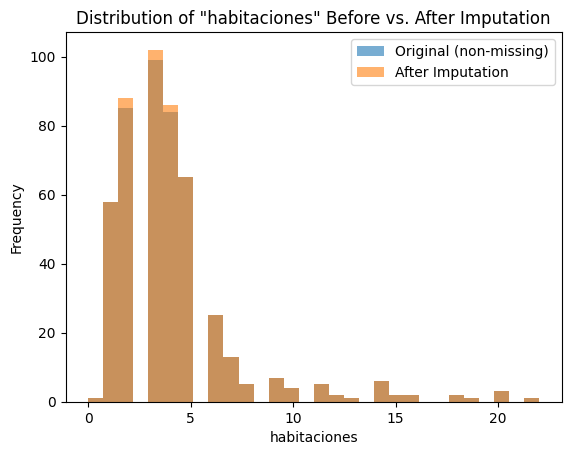

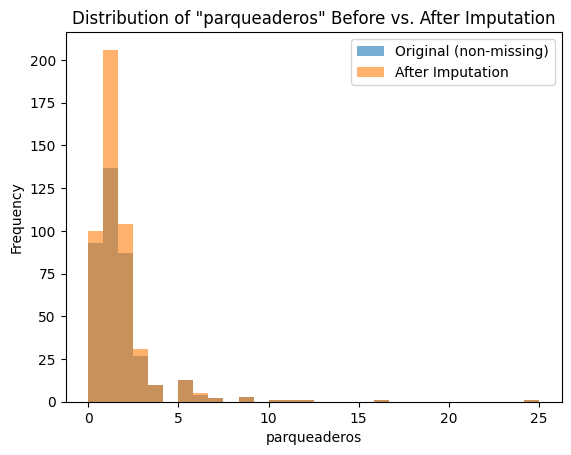

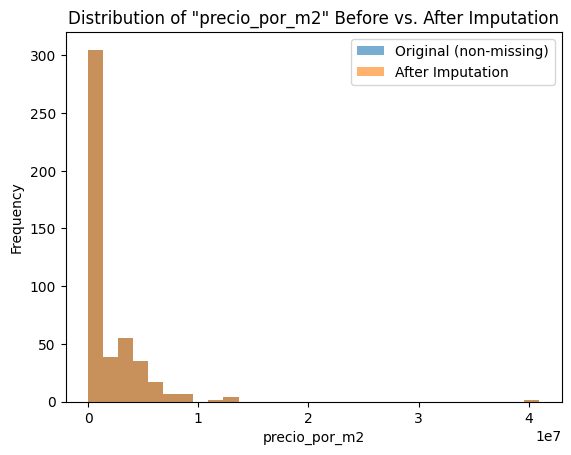

In [39]:
def plot_imputation_distributions(original_df, imputed_df, columns, bins=30):
    """
    Plots the distribution of specified numeric columns before and after imputation.
    
    Parameters:
    - original_df: DataFrame with missing values.
    - imputed_df: DataFrame with imputed values.
    - columns: List of column names to compare.
    - bins: Number of bins for the histograms.
    """
    for col in columns:
        if col not in original_df.columns or col not in imputed_df.columns:
            print(f"Column '{col}' not found in both DataFrames.")
            continue
        
        # Drop missing values from the original for fair comparison
        orig_values = original_df[col].dropna()
        imp_values = imputed_df[col]
        
        plt.figure()
        plt.hist(orig_values, bins=bins, alpha=0.6, label='Original (non-missing)')
        plt.hist(imp_values, bins=bins, alpha=0.6, label='After Imputation')
        plt.title(f'Distribution of "{col}" Before vs. After Imputation')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()


plot_imputation_distributions(data, data_imputed_knn, ['area', 'precio', 'baños', 'habitaciones', 'parqueaderos', "precio_por_m2"], bins=30)


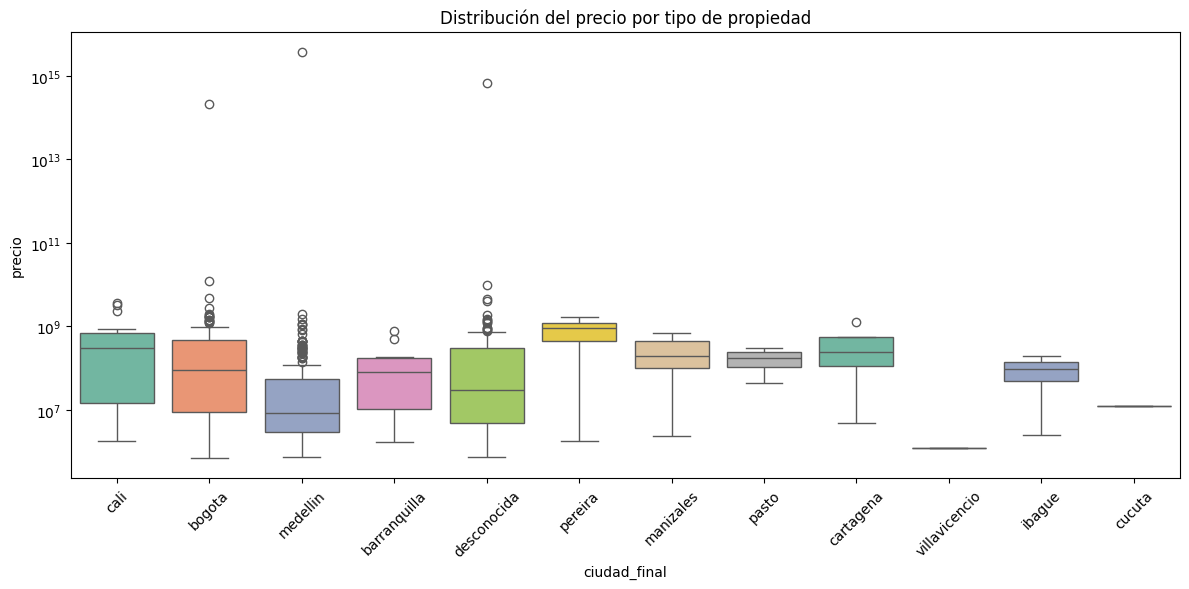

In [40]:

# Viendo la distribucion del precio en tipo de propiedad Apartamento en arriendo vs Apartamento en venta
plt.figure(figsize=(12, 6))
sns.boxplot(x='ciudad_final', y='precio', data=data_imputed_knn, palette='Set2')
plt.title('Distribución del precio por tipo de propiedad')
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [41]:
from scipy.stats import shapiro
from scipy.stats import levene



In [42]:
num_cols = ['precio',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'precio_por_m2']

In [43]:

for ciudad, grupo in data_imputed_knn.groupby('ciudad_final'):
    print(f"\nCiudad: {ciudad}")
    for col in num_cols:
        valores = grupo[col].dropna()
        if len(valores) >= 3:  # Ensure there are at least 3 data points
            stat, p = shapiro(valores)
            print(f"  {col}: W={stat:.3f}, p={p:.3f}")
        else:
            print(f"  {col}: Not enough data for Shapiro-Wilk test (n={len(valores)})")


Ciudad: barranquilla
  precio: W=0.734, p=0.002
  habitaciones: W=0.877, p=0.121
  baños: W=0.767, p=0.006
  parqueaderos: W=0.832, p=0.035
  area: W=0.845, p=0.051
  precio_por_m2: W=0.743, p=0.003

Ciudad: bogota
  precio: W=0.055, p=0.000
  habitaciones: W=0.773, p=0.000
  baños: W=0.786, p=0.000
  parqueaderos: W=0.689, p=0.000
  area: W=0.355, p=0.000
  precio_por_m2: W=0.518, p=0.000

Ciudad: cali
  precio: W=0.646, p=0.000
  habitaciones: W=0.791, p=0.000
  baños: W=0.766, p=0.000
  parqueaderos: W=0.850, p=0.004
  area: W=0.737, p=0.000
  precio_por_m2: W=0.871, p=0.010

Ciudad: cartagena
  precio: W=0.838, p=0.189
  habitaciones: W=0.791, p=0.086
  baños: W=0.895, p=0.405
  parqueaderos: W=0.827, p=0.161
  area: W=0.700, p=0.011
  precio_por_m2: W=0.978, p=0.892

Ciudad: cucuta
  precio: Not enough data for Shapiro-Wilk test (n=1)
  habitaciones: Not enough data for Shapiro-Wilk test (n=1)
  baños: Not enough data for Shapiro-Wilk test (n=1)
  parqueaderos: Not enough data fo

La mayoría de las ciudades tienen p < 0.05, lo que indica que los precios no siguen una distribución normal. <br>
Algunas de las variables si otras no, la variable de interes no

In [44]:
muestras = [grupo['precio'].dropna() for _, grupo in data_imputed_knn.groupby('ciudad_final')]
stat, p = levene(*muestras)
print(f"Levene: stat={stat:.3f}, p={p:.3f}")


Levene: stat=0.110, p=1.000



p = 0.991  Se cumple la homogeneidad de varianzas para area.

In [45]:
from scipy.stats import kruskal

def comparar_ciudades_kruskal(df, columnas):
    resultados = []

    for col in columnas:
        grupos = [
            grupo[col].dropna() 
            for ciudad, grupo in df.groupby('ciudad_final') 
            if grupo[col].dropna().shape[0] >= 3
        ]

        if len(grupos) >= 2:
            stat, p = kruskal(*grupos)
            resultados.append({
                'variable': col,
                'stat': stat,
                'p_value': p,
                'diferencia_significativa': p < 0.05
            })

    return pd.DataFrame(resultados).sort_values('p_value')


In [46]:
comparar_ciudades_kruskal(data_imputed_knn, num_cols)


,variable,stat,p_value,diferencia_significativa
0,precio,43.838424,2.296675e-07,True
2,baños,26.344727,4.369897e-04,True
5,precio_por_m2,23.466507,1.413199e-03,True
3,parqueaderos,21.960495,2.580557e-03,True
1,habitaciones,20.111959,5.332864e-03,True
4,area,5.181761,6.377929e-01,False


# Modelamiento


Es mejor hacer un tratamiento de outliers para cada ciudad pero tambien seria mejor usar una imputacion para cada ciudad

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
# TextBlob para análisis de sentimientos
from textblob import TextBlob


In [48]:
df_medellin = data_imputed_knn[data_imputed_knn['ciudad_final'] == 'medellin']
df_medellin.shape

(183, 11)

In [49]:
df_medellin.columns.tolist()

['precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_final',
 'precio_por_m2']

Transformar la columna `descripcion` en vectores numéricos que capturen la importancia de términos relevantes, y luego reducir la alta dimensionalidad para mejorar eficiencia y evitar ruido en el modelo.


  
- Creamos `stop_terms`, una lista de palabras muy frecuentes en anuncios inmobiliarios (baños, habitaciones, m², casa, apartamento, etc.) y que no presentan relevancia ya que hay otras columnas con la misma información 
- Combinamos con las stop words generales en español de NLTK (`stopwords.words('spanish')`).  


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
# Define custom stop words
stop_terms = ['baño', 'baños', 'habitacion', 'habitaciones',
              'parqueadero', 'parqueaderos', 'm²', 'metros', 'area', "alcoba", "alcobas", "wc", "metros",
              "m2", "cuartos", "cuarto", "dormitorio", "dormitorios", "mts", "mt2", "metro", "garaje", 
              "parqueo", 'parking', 'cocheras', 'aparca', 'aparcamiento', 'sanitario', 'sanitarios'
                , 'arriendo', 'arriendo', 'apartamento', 'apartamentos', 'apartamento', 'apartamentos', 
                'casa', 'casas', 'casa', 'casas', 'lote', 'lotes', 'lote', 'lotes',
                'arrriendo', "bodega", "bodegas"]

# Combine custom stop words with NLTK's English stop words
nltk_stop_words = stopwords.words('spanish') 
combined_stop_words = stop_terms + nltk_stop_words

# Initialize TfidfVectorizer
tfidf = TfidfVectorizer(
    max_features=200,  # Limit to the 200 most significant words
    min_df=10,         # Ignore terms that appear in fewer than 10 documents
    max_df=0.7,        # Ignore terms that appear in more than 70% of documents
    ngram_range=(1, 2),  # Consider unigrams and bigrams
    stop_words=combined_stop_words
)

# Fit and transform the descriptions
descripciones_tfidf = tfidf.fit_transform(df_medellin['descripcion']) #Obtenemos una matriz dispersa (sparse) de tamaño (n_registros, n_features).



In [51]:
tfidf_df = pd.DataFrame(
    descripciones_tfidf.toarray(),
    columns=tfidf.get_feature_names_out()
) # se hace dataframe 
print(f"Número de características extraídas con TF-IDF: {len(tfidf.get_feature_names_out())}")


Número de características extraídas con TF-IDF: 167


In [52]:
# Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=42) #Reducimos a 50 componentes densos.
descripciones_svd = svd.fit_transform(descripciones_tfidf)
print(f"Número de componentes después de SVD: {descripciones_svd.shape[1]}")


Número de componentes después de SVD: 50


In [53]:
# Mostrar las 20 palabras más comunes según TF-IDF
feature_importances = np.mean(descripciones_tfidf.toarray(), axis=0)
palabras_importantes = [(palabra, importancia) 
                         for palabra, importancia in zip(tfidf.get_feature_names_out(), feature_importances)]
palabras_importantes = sorted(palabras_importantes, key=lambda x: x[1], reverse=True)[:20]
print("\nPalabras más importantes según TF-IDF:")
for palabra, importancia in palabras_importantes:
    print(f"{palabra}: {importancia:.4f}")



Palabras más importantes según TF-IDF:
cuenta: 0.0703
zona: 0.0656
piso: 0.0650
sector: 0.0635
excelente: 0.0624
cocina: 0.0533
cerca: 0.0511
acceso: 0.0508
ubicado: 0.0473
comercial: 0.0441
ideal: 0.0421
área: 0.0418
ubicada: 0.0400
comedor: 0.0386
sala: 0.0386
unidad: 0.0377
centro: 0.0371
transporte: 0.0368
sala comedor: 0.0367
integral: 0.0357


In [124]:
df_medellin['descripcion_sentiment'] = df_medellin['descripcion'].apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

Vocabulario local

Cada zona o ciudad emplea términos y jergas propias (p. ej. “milla de oro” vs. “estadio”).

Un TF‑IDF segmentado captura esas palabras distintivas y evita que queden diluidas por el corpus total.

detectas patrones de texto propios de cada área, resaltan términos relevantes dentro del segmento.

Se tienen pocos datos para cada ciudad por lo que se eliminan estas columnas problematicas se van a tener aun menos datos

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
import nltk
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings('ignore')
import unicodedata


In [126]:
#feature engineering
df_medellin['room_density'] = df_medellin['habitaciones'] / df_medellin['area']
df_medellin['bathroom_density'] = df_medellin['baños'] / df_medellin['area']
df_medellin['longitud_descripcion'] = df_medellin['descripcion'].apply(
    lambda x: len(str(x)) if isinstance(x, str) else 0
)
corr_longitud_precio = df_medellin[['longitud_descripcion', 'precio']].corr().iloc[0,1]
print(f"\nCorrelación entre longitud de descripción y precio: {corr_longitud_precio:.4f}")


Correlación entre longitud de descripción y precio: -0.1088


In [55]:
df_medellin.columns.tolist()

['precio',
 'ubicacion',
 'habitaciones',
 'baños',
 'parqueaderos',
 'area',
 'descripcion',
 'tipo_propiedad',
 'georeferencia',
 'ciudad_final',
 'precio_por_m2']

In [128]:
num_cols = ['habitaciones', 'baños', 'parqueaderos', 'area', 'longitud_descripcion', 'room_density', 'bathroom_density']
cat_cols = ['tipo_propiedad', 'ubicacion'] # Ubicacion no se esta teniendo en cuenta debido a su falta de estructura entonces añade dimensionalidad al modelo
text_cols = ['descripcion']

In [56]:
import pandas as pd
import numpy as np
from scipy import stats

def remove_extreme_outliers_with_flag(data, zscore_threshold=5):
    """
    Elimina outliers extremos basados en Z-score muy alto para todas las columnas numéricas.
    Devuelve un DataFrame con los outliers separados e indica en qué columna(s) fueron detectados.
    """
    initial_rows = len(data)
    outliers_dict = {}

    # Calcular Z-scores para todas las columnas numéricas
    for col in data.select_dtypes(include=['float64', 'int64']).columns.difference(['longitud_descripcion',"descripcion_sentiment"]):
        z_scores = np.abs(stats.zscore(data[col], nan_policy='omit'))
        col_outliers_indices = data[z_scores > zscore_threshold].index
        for index in col_outliers_indices:
            if index not in outliers_dict:
                outliers_dict[index] = {'outlier_in': [col]}
            else:
                outliers_dict[index]['outlier_in'].append(col)

    outliers_indices = list(outliers_dict.keys())

    # Crear DataFrame de outliers
    outliers_df = data.loc[outliers_indices].copy()  # Usamos .copy() para evitar warnings
    outliers_df['outlier_in'] = [outliers_dict[idx]['outlier_in'] for idx in outliers_indices]

    # Eliminar outliers extremos del DataFrame original
    data_filtered = data.drop(index=outliers_indices)

    removed_rows = initial_rows - len(data_filtered)
    print(f"Se eliminaron {removed_rows} filas con outliers extremos ({removed_rows/initial_rows:.2%} del dataset)")

    return data_filtered, outliers_df




In [57]:
data_filtered, outliers_df = remove_extreme_outliers_with_flag(df_medellin, zscore_threshold=1)
outliers_df.head(10)
# imprimiendo outliers en precio y area
outliers_df[outliers_df['outlier_in'].apply(lambda x: 'precio' in x or 'area' in x)]

Se eliminaron 45 filas con outliers extremos (24.59% del dataset)


,precio,ubicacion,habitaciones,baños,parqueaderos,area,descripcion,tipo_propiedad,georeferencia,ciudad_final,precio_por_m2,outlier_in
184,7400000,"rionegro, guarne, obrero",4,4,2,1880.00,casa arriendo ubicada sector campestre flujo v...,Casa en arriendo,punto mayor,medellin,3.936170e+03,[area]
209,30000000,"florida, altos del poblado, castropol",5,5,1,1500.00,codigo 20207 casa amoblada arriendo ubicada po...,Casa en arriendo,tesoro,medellin,2.000000e+04,[area]
358,2005000000,"calera, plazuela, alto de virgen",5,8,2,1000.00,itau hermosa casa campestre calera parque resi...,Casa en venta,centro,medellin,2.005000e+06,[area]
391,55779470,"rionegro, lotus i, porvenir",1,1,1,1923.00,excelente oportunidad arriendo zona franca rio...,Bodega en arriendo,zona franca,medellin,2.900648e+04,[area]
413,26000000,"rionegro, obrero, punto mayor",2,1,0,1000.00,bodega arriendo guarne sector mosquita excelen...,Bodega en arriendo,mosquita,medellin,2.600000e+04,[area]
424,60800000,"zona centro, aguacatala, bosques de zuniga",3,2,0,1600.00,bodega arriendo itagui sector mayorista excele...,Bodega en arriendo,mayorista,medellin,3.800000e+04,[area]
430,16500000,"bosques de zuniga, portal, itagui",3,0,1,1080.00,arrienda bodega sector aguacatala medellín cue...,Bodega en arriendo,santa maria 1 guayabo,medellin,1.527778e+04,[area]
449,55800000,"porvenir, rionegro, santa ana",4,4,0,1923.00,bodega arriendo rionegro aeropuerto zona franc...,Bodega en arriendo,vereda aeropuerto,medellin,2.901716e+04,[area]
450,50875000,"simon bolivar sb (centro), guasimalito, azulita",4,0,1,2034.00,bodega arriendo bello parque empresarial norti...,Bodega en arriendo,villas copacabana,medellin,2.501229e+04,[area]
457,36500000,"zona centro, bosques de zuniga, santa maria de...",4,0,2,1350.00,bodega alquiler itagui cuenta espacio ideal fa...,Bodega en arriendo,capricentro,medellin,2.703704e+04,[area]


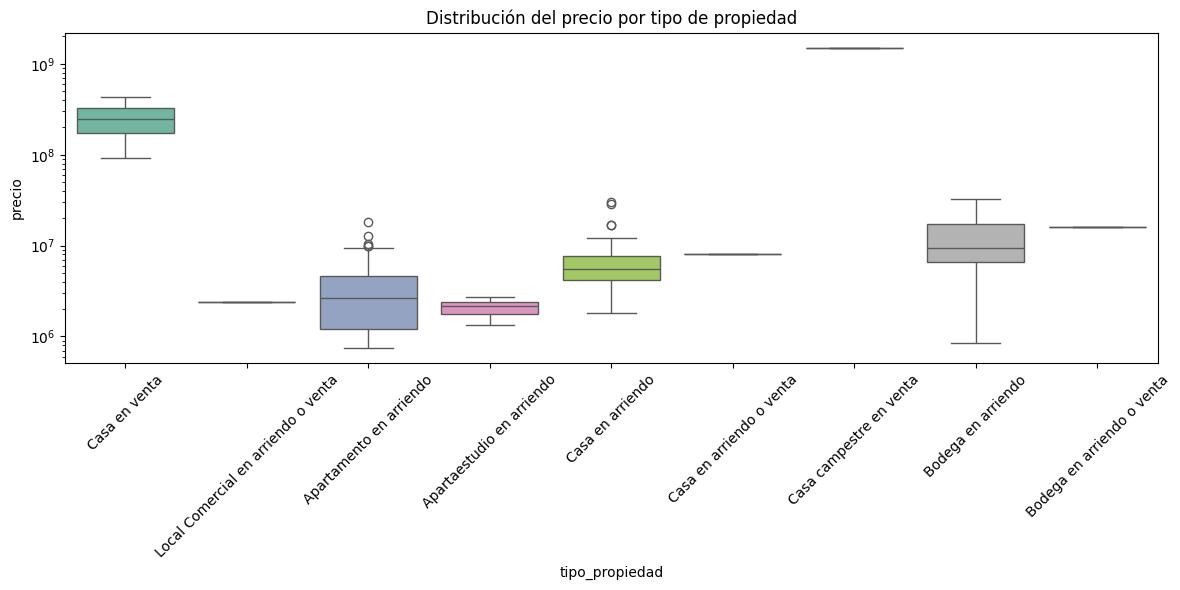

In [58]:
data_filtered['tipo_propiedad'].value_counts()
# Viendo la distribucion del precio en tipo de propiedad Apartamento en arriendo vs Apartamento en venta
plt.figure(figsize=(12, 6))
sns.boxplot(x='tipo_propiedad', y='precio', data=data_filtered, palette='Set2')
plt.title('Distribución del precio por tipo de propiedad')
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [59]:

def comparar_propiedades_kruskal(df, columnas):
    resultados = []

    for col in columnas:
        grupos = [
            grupo[col].dropna() 
            for ciudad, grupo in df.groupby('tipo_propiedad') 
            if grupo[col].dropna().shape[0] >= 3
        ]

        if len(grupos) >= 2:
            stat, p = kruskal(*grupos)
            resultados.append({
                'variable': col,
                'stat': stat,
                'p_value': p,
                'diferencia_significativa': p < 0.05
            })

    return pd.DataFrame(resultados).sort_values('p_value')

comparar_propiedades_kruskal(data_filtered, num_cols + ["precio"])


,variable,stat,p_value,diferencia_significativa
4,area,72.005018,8.561309e-15,True
0,precio,59.706194,3.343978e-12,True
6,precio,59.706194,3.343978e-12,True
1,habitaciones,59.375348,3.924378e-12,True
2,baños,56.591624,1.506921e-11,True
5,precio_por_m2,39.714730,4.958102e-08,True
3,parqueaderos,4.998494,2.874521e-01,False


Se notan diferencias significativas en las caracteristicas de los diferentes tipos de propiedades. <br>
Por lo que intentar modelar ... <br>
Y la variable objetivo "precio" tambien hay diferencia significativa por lo que lo remendando seria ... <br>
Igual vamos a continuar con la modelación completa 

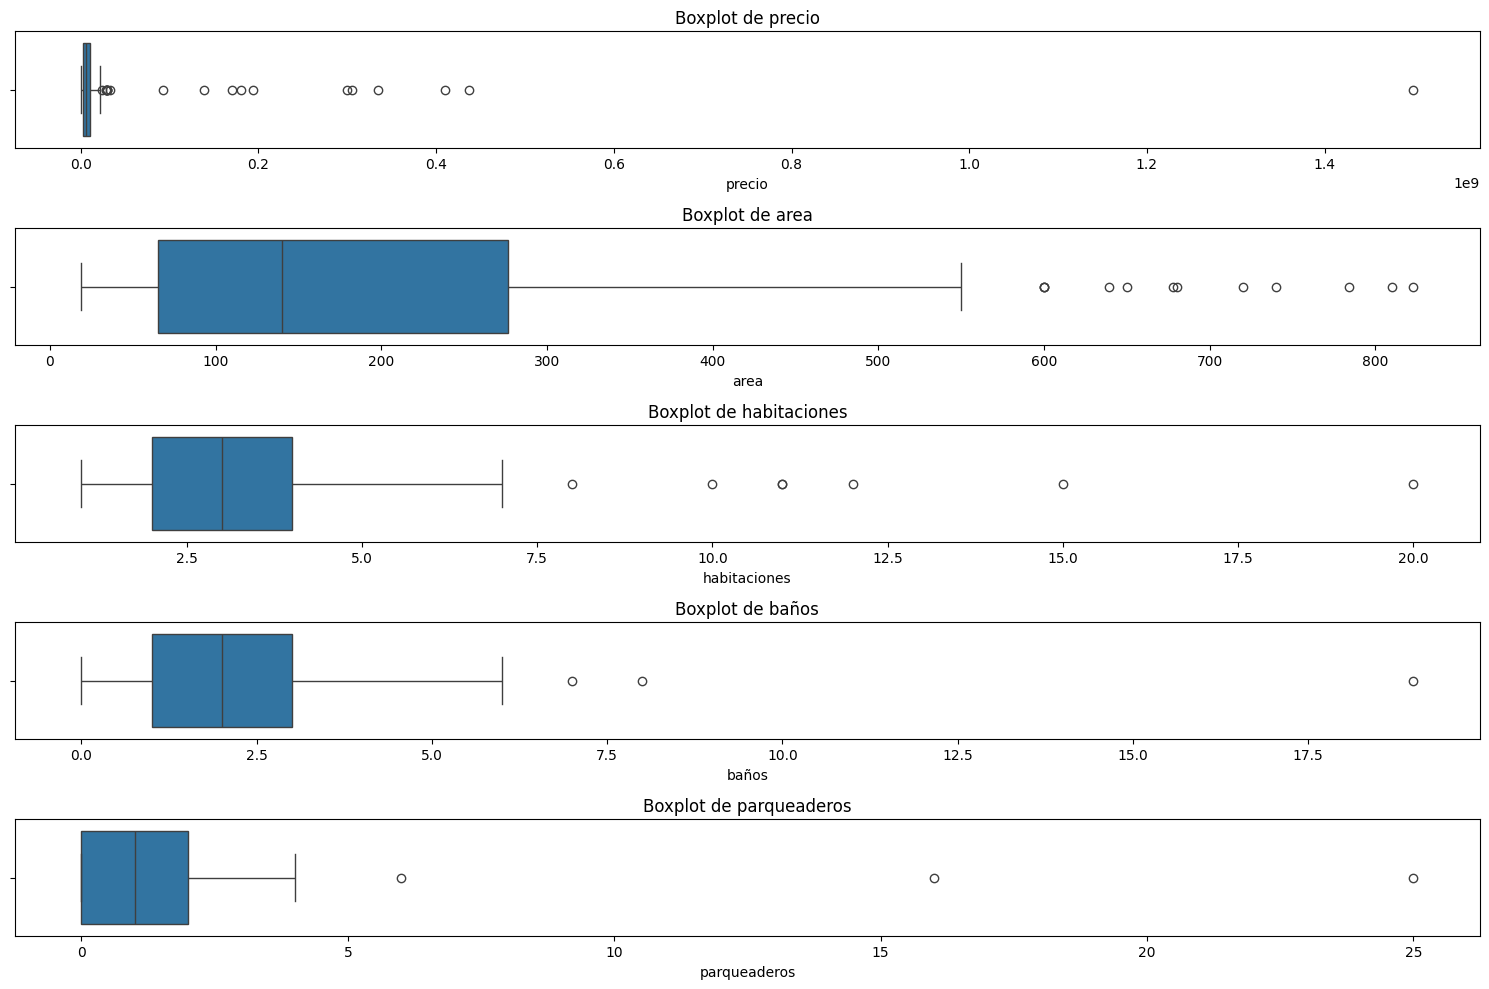

             precio        area  habitaciones       baños  parqueaderos
count  1.380000e+02  138.000000    138.000000  138.000000    138.000000
mean   3.612892e+07  209.466667      3.528986    2.333333      1.427536
std    1.445917e+08  193.827056      2.731786    2.152348      2.610724
min    7.500000e+05   19.000000      1.000000    0.000000      0.000000
25%    2.425000e+06   65.500000      2.000000    1.000000      0.000000
50%    5.500000e+06  140.000000      3.000000    2.000000      1.000000
75%    1.037500e+07  276.500000      4.000000    3.000000      2.000000
max    1.500000e+09  823.000000     20.000000   19.000000     25.000000


In [60]:
plot_outliers(data_filtered, ['precio', 'area', 'habitaciones', 'baños', 'parqueaderos'])

1. **Distribuciones locales vs. globales**  
   - Cada ciudad puede tener una escala y dispersión de precios muy distinta (p. ej. El Poblado vs. Belén).  
   - Un umbral global (media ± k·desviación) podría tratar precios válidos en una ciudad cara como “outliers” o dejar pasar atípicos de una ciudad más barata.

2. **Detección adaptada al contexto**  
   - Al calcular z‑score o IQR _dentro_ de cada grupo, obtenemos umbrales que reflejan la dispersión real de ese mercado local.  
   - Ejemplo: en “Medellín Centro” la desviación típica puede ser $30 M COP, en “Envigado” $50 M COP. Detectar outliers con cada σ local evita sesgos.

3. **Mejor conservación de patrones**  
   - Preservas la heterogeneidad real entre zonas: los precios típicos de una comuna no “ensucian” el análisis de otra.  
   - Ayuda a mantener la señal predictiva asociada al contexto geográfico.


## Intentando reducir dimensionalidad

In [61]:
#print(data_filtered['ubicacion'].unique())
data_filtered['georeferencia'].value_counts()

georeferencia
san antonio prado    18
poblado              11
rionegro             10
antioquia             5
medellin              5
                     ..
belen palma           1
mesa                  1
trece noviembre       1
velodromo             1
colombia              1
Name: count, Length: 76, dtype: int64

In [62]:
zona_dict_mejorado = {
    # Zona 1: Nororiental (Comunas 1–4)
    'Nororiental': [
        'popular', 'santo domingo', 'santa cruz', 'manrique', 'aranjuez', 
        'jardín botánico', 'universidad de antioquia', 'campo valdés', 'moravia',
        'playón', 'villa del socorro', 'granizal', 'moscú', 'villa guadalupe',
        'san pablo', 'la salle', 'brasilia', 'la rosa', 'berlín', 'carpinelo',
        'san isidro', 'palermo', 'miranda', 'la frontera', 'la francia', 'andalucía',
        'villa niza', 'la isla', 'el raizal', 'el pomar', 'versalles', 'jardines', 
        'comuna 1', 'comuna 2', 'comuna 3', 'comuna 4'
    ],

    # Zona 2: Noroccidental (Comunas 5–7)
    'Noroccidental': [
        'castilla', 'robledo', 'doce de octubre', 'pedregal', 'la esperanza',
        'san martín de porres', 'alfonso lópez', 'boyacá', 'florencia', 'tejelo',
        'belalcázar', 'girardot', 'tricentenario', 'héctor abad', 'kennedy',
        'picacho', 'picachito', 'mirador', 'aures', 'cuatro esquinas', 'cerro volador',
        'bello horizonte', 'córdoba', 'lópez de mesa', 'altamira', 'Francisco Antonio Zea',
        'plaza de ferias', 'nuevo pascual bravo', 'comuna 5', 'comuna 6', 'comuna 7'
    ],

    # Zona 3: Centrooccidental (Comunas 11–13)
    'Centrooccidental': [
        'la américa', 'san javier', 'laureles', 'estadio', 'floresta', 'santa lucía',
        'los colores', 'carlos e. restrepo', 'suramericana', 'simón bolívar', 'calasanz',
        'santa teresita', 'conquistadores', 'naranjal', 'florida nueva', 'cristóbal',
        'belencito', 'antonio nariño', 'el corazón', 'veinte de julio', 'blanquizal',
        'las independencias', 'nuevos conquistadores', 'el salado', 'betania', 'cuarta brigada',
        'san joaquín', 'la castellana', 'lorena', 'bolivariana', 'comuna 11', 'comuna 12', 'comuna 13'
    ],

    # Zona 4: Centroriental (Comunas 8–10)
    'Centroriental': [
        'villa hermosa', 'buenos aires', 'candelaria', 'prado', 'boston', 'centro',
        'villanueva', 'la ladera', 'san miguel', 'la mansión', 'batallón', 'sucre',
        'los ángeles', 'bomboná', 'el chagualo', 'la candelaria', 'san benito', 'guayaquil',
        'corazón de jesús', 'estación villa', 'san diego', 'perpetuo socorro', 'colón',
        'enciso', 'llanaditas', 'la libertad', 'villatina', 'caicedo', 'la toma',
        'el salvador', 'gerona', 'las palmas', 'comuna 8', 'comuna 9', 'comuna 10', 'palmas'
    ],

    # Zona 5: Suroriental (Comuna 14)
    'Suroriental': [
        'el poblado', 'milla de oro', 'loma de los balsos', 'tesoro', 'castropol',
        'lalinde', 'las lomas', 'altos del poblado', 'patio bonito', 'manila',
        'astorga', 'provenza', 'villa carlota', 'santa maría de los ángeles', 
        'parque lleras', 'alejandría', 'la aguacatala', 'los naranjos', 'el diamante',
        'san lucas', 'la florida', 'el castillo', 'vizcaya', 'santa fe', 'las vegas',
        'los balsos', 'la calera', 'el poblado de oro', 'palmitas', 'los gonzalez',
        'zona rosa', 'la frontera', 'oviedo', 'santafe', 'ciudad del río', 'comuna 14', 'poblado', 'sabaneta', 'envigado', 'naranjos', 'naranjitos'
    ],

    # Zona 6: Suroccidental (Comunas 15–16)
    'Suroccidental': [
        'guayabal', 'belen', 'conquistadores', 'rosales', 'la mota', 'diego echavarría',
        'las mercedes', 'fatima', 'nutibara', 'la gloria', 'aliadas', 'santa fe',
        'san bernardo', 'la palma', 'los alpes', 'la hondonada', 'altavista', 'trinidad',
        'campo amor', 'cristo rey', 'la colinita', 'mallorca', 'los almendros', 'el rodeo',
        'parque juan pablo', 'la nubia', 'el rincón', 'granada', 'zafra', 'villa café',
        'miravalle', 'comuna 15', 'comuna 16', 'itagui', 'ditaires'
    ],
    
    # Corregimientos (áreas rurales de Medellín)
    'Corregimientos': [
        'san antonio de prado', 'san cristóbal', 'altavista', 'san sebastián de palmitas',
        'santa elena', 'corregimiento', 'rural', 'rio negro' , 'rionegro'
    ]
}

In [ ]:
def asignar_zona_mejorada(ubicacion_raw, georeferencia_raw, zona_dict):
    """
    Asigna una zona basada en la fusión de 'ubicacion_raw' y 'georeferencia_raw',
    usando un enfoque robusto de normalización y búsqueda de keywords.
    """
    # Si ambos campos están vacíos o NaN
    if pd.isna(ubicacion_raw) and pd.isna(georeferencia_raw):
        return 'Sin ubicación'
    
    # Construir un único texto concatenado
    texto = f"{ubicacion_raw or ''} {georeferencia_raw or ''}"
    texto = texto.lower()
    
    # Eliminar acentos y caracteres especiales
    texto = unicodedata.normalize('NFKD', texto)\
                       .encode('ASCII', 'ignore')\
                       .decode('utf-8')
    texto = re.sub(r'[^\w\s]', ' ', texto)  # Reemplazar símbolos con espacios
    
    # 1) Buscar coincidencias exactas o con sufijos
    for zona, keywords in zona_dict.items():
        for kw in keywords:
            kw_norm = unicodedata.normalize('NFKD', kw)\
                                  .encode('ASCII', 'ignore')\
                                  .decode('utf-8')
            pattern = rf"\b{re.escape(kw_norm)}\b|\b{re.escape(kw_norm)}[a-z]+"
            if re.search(pattern, texto):
                return zona
    
    # 2) Si no halló nada, buscar coincidencias parciales
    for zona, keywords in zona_dict.items():
        for kw in keywords:
            if kw.lower() in texto:
                return zona
    
    return 'Otra'


# Función para analizar los resultados de la clasificación
def analizar_clasificacion_zonas(df, col_ubicacion, col_zona):
    """
    Analiza los resultados de la clasificación de zonas y muestra ejemplos
    de ubicaciones clasificadas en cada zona y de ubicaciones no clasificadas.
    """
    resultados = {
        'total': len(df),
        'clasificados': (df[col_zona] != 'Otra').sum(),
        'no_clasificados': (df[col_zona] == 'Otra').sum(),
        'distribucion': df[col_zona].value_counts(),
        'porcentaje_clasificado': (df[col_zona] != 'Otra').mean() * 100
    }
    
    print(f"Total de registros: {resultados['total']}")
    print(f"Registros clasificados: {resultados['clasificados']} ({resultados['porcentaje_clasificado']:.2f}%)")
    print(f"Registros no clasificados: {resultados['no_clasificados']}")
    print("\nDistribución por zonas:")
    print(resultados['distribucion'])
    
    # Mostrar ejemplos de cada zona
    print("\nEjemplos de ubicaciones por zona:")
    for zona in df[col_zona].unique():
        if zona != 'Otra':
            muestra = df[df[col_zona] == zona][col_ubicacion].sample(min(3, df[df[col_zona] == zona].shape[0]))
            print(f"\n{zona}:")
            for ubicacion in muestra:
                print(f"- {ubicacion}")
    
    # Mostrar ejemplos de no clasificados
    if resultados['no_clasificados'] > 0:
        print("\nEjemplos de ubicaciones no clasificadas ('Otra'):")
        muestra_no_clasificados = df[df[col_zona] == 'Otra'][col_ubicacion].sample(min(10, resultados['no_clasificados']))
        for ubicacion in muestra_no_clasificados:
            print(f"- {ubicacion}")
    
    return resultados

In [66]:
zona_dict_mejorado = {
    # Zona 1: Nororiental (Comunas 1–4)
    'Nororiental': [
        'popular', 'santo domingo', 'santa cruz', 'manrique', 'aranjuez', 
        'jardín botánico', 'universidad de antioquia', 'campo valdés', 'moravia',
        'playón', 'villa del socorro', 'granizal', 'moscú', 'villa guadalupe',
        'san pablo', 'la salle', 'brasilia', 'la rosa', 'berlín', 'carpinelo',
        'san isidro', 'palermo', 'miranda', 'la frontera', 'la francia', 'andalucía',
        'villa niza', 'la isla', 'el raizal', 'el pomar', 'versalles', 'jardines', 
        'comuna 1', 'comuna 2', 'comuna 3', 'comuna 4'
    ],

    # Zona 2: Noroccidental (Comunas 5–7)
    'Noroccidental': [
        'castilla', 'robledo', 'doce de octubre', 'pedregal', 'la esperanza',
        'san martín de porres', 'alfonso lópez', 'boyacá', 'florencia', 'tejelo',
        'belalcázar', 'girardot', 'tricentenario', 'héctor abad', 'kennedy',
        'picacho', 'picachito', 'mirador', 'aures', 'cuatro esquinas', 'cerro volador',
        'bello horizonte', 'córdoba', 'lópez de mesa', 'altamira', 'Francisco Antonio Zea',
        'plaza de ferias', 'nuevo pascual bravo', 'comuna 5', 'comuna 6', 'comuna 7'
    ],

    # Zona 3: Centrooccidental (Comunas 11–13)
    'Centrooccidental': [
        'la américa', 'san javier', 'laureles', 'estadio', 'floresta', 'santa lucía',
        'los colores', 'carlos e. restrepo', 'suramericana', 'simón bolívar', 'calasanz',
        'santa teresita', 'conquistadores', 'naranjal', 'florida nueva', 'cristóbal',
        'belencito', 'antonio nariño', 'el corazón', 'veinte de julio', 'blanquizal',
        'las independencias', 'nuevos conquistadores', 'el salado', 'betania', 'cuarta brigada',
        'san joaquín', 'la castellana', 'lorena', 'bolivariana', 'comuna 11', 'comuna 12', 'comuna 13'
    ],

    # Zona 4: Centroriental (Comunas 8–10)
    'Centroriental': [
        'villa hermosa', 'buenos aires', 'candelaria', 'prado', 'boston', 'centro',
        'villanueva', 'la ladera', 'san miguel', 'la mansión', 'batallón', 'sucre',
        'los ángeles', 'bomboná', 'el chagualo', 'la candelaria', 'san benito', 'guayaquil',
        'corazón de jesús', 'estación villa', 'san diego', 'perpetuo socorro', 'colón',
        'enciso', 'llanaditas', 'la libertad', 'villatina', 'caicedo', 'la toma',
        'el salvador', 'gerona', 'las palmas', 'comuna 8', 'comuna 9', 'comuna 10', 'palmas'
    ],

    # Zona 5: Suroriental (Comuna 14)
    'Suroriental': [
        'el poblado', 'milla de oro', 'loma de los balsos', 'tesoro', 'castropol',
        'lalinde', 'las lomas', 'altos del poblado', 'patio bonito', 'manila',
        'astorga', 'provenza', 'villa carlota', 'santa maría de los ángeles', 
        'parque lleras', 'alejandría', 'la aguacatala', 'los naranjos', 'el diamante',
        'san lucas', 'la florida', 'el castillo', 'vizcaya', 'santa fe', 'las vegas',
        'los balsos', 'la calera', 'el poblado de oro', 'palmitas', 'los gonzalez',
        'zona rosa', 'la frontera', 'oviedo', 'santafe', 'ciudad del río', 'comuna 14', 'poblado', 'sabaneta', 'envigado', 'naranjos', 'naranjitos'
    ],

    # Zona 6: Suroccidental (Comunas 15–16)
    'Suroccidental': [
        'guayabal', 'belen', 'conquistadores', 'rosales', 'la mota', 'diego echavarría',
        'las mercedes', 'fatima', 'nutibara', 'la gloria', 'aliadas', 'santa fe',
        'san bernardo', 'la palma', 'los alpes', 'la hondonada', 'altavista', 'trinidad',
        'campo amor', 'cristo rey', 'la colinita', 'mallorca', 'los almendros', 'el rodeo',
        'parque juan pablo', 'la nubia', 'el rincón', 'granada', 'zafra', 'villa café',
        'miravalle', 'comuna 15', 'comuna 16', 'itagui', 'ditaires'
    ],
    
    # Corregimientos (áreas rurales de Medellín)
    'Corregimientos': [
        'san antonio de prado', 'san cristóbal', 'altavista', 'san sebastián de palmitas',
        'santa elena', 'corregimiento', 'rural', 'rio negro' , 'rionegro'
    ]
}

In [67]:
df_medellin['zona'] = df_medellin.apply(
    lambda fila: asignar_zona_mejorada(
        fila['ubicacion'],
        fila['georeferencia'],
        zona_dict_mejorado
    ),
    axis=1
)
resultados = analizar_clasificacion_zonas(df_medellin, 'ubicacion', 'zona')

Total de registros: 183
Registros clasificados: 171 (93.44%)
Registros no clasificados: 12

Distribución por zonas:
zona
Centroriental       75
Centrooccidental    38
Suroriental         35
Otra                12
Corregimientos       9
Nororiental          5
Noroccidental        5
Suroccidental        4
Name: count, dtype: int64

Ejemplos de ubicaciones por zona:

Centroriental:
- mesa, zona centro, dorado
- ditaires, santa catalina, ferreria
- castropol, simesa, san diego

Suroriental:
- tesoro, alejandria, florida
- castropol, simesa, altos del poblado
- mesa, envigado, inmaculada

Centrooccidental:
- candelaria, san diego, conquistadores
- lorena, colores, calasanz
- simesa, conquistadores, castropol

Suroccidental:
- bosques de zuniga, portal, itagui
- ditaires, santa catalina, ancon san martin
- ditaires, santa catalina, ancon san martin

Nororiental:
- candelaria, medellin, boston
- mesa, zona centro, inmaculada
- santa rosa de lima, colores, estadio

Corregimientos:
- rionegro, 

In [68]:
df_medellin[df_medellin['zona'] == 'Otra']['ubicacion'].unique()

array(['soacha, san luis, . terreros',
       'cabanita, zona industrial no. 1, cabana',
       'ciudadela del , a.s.d., navarra',
       'villa del rio, madelena iii y iv, venecia',
       'entre amigos, vegas de doctora, vegas de san jose',
       'conjunto residencial villa campestre, br villa estrella, cr. coralina',
       'corzo, parcela porvenir, cr torres progreso . i',
       'bosconia, a.s.d., predio caldas',
       'mt cerro campestre alto, vereda samaria',
       'villa blanca, universal, alboraya',
       'bodega industrial en dorado area de 1.950 metros construccion total, area libre de bodega a triple altura de 1.704 metros, mas oficinas de 200 metros, mas zona de parqueo privado 170 metros, capacitad d energia de 35 kwa, bodega con tres entradas pisos de alta resistencia,',
       'alpes, angeles, sector plaza de bolivar'], dtype=object)

Yo esos datos los veo muy raros, yo los eliminaria pero como tenemos pocos datos...


In [69]:
# Filter rows where 'tipo_propiedad' contains 'venta'
venta_medellin = df_medellin[df_medellin['tipo_propiedad'].str.contains('venta', case=False, na=False)]
venta_medellin['tipo_propiedad'] = venta_medellin['tipo_propiedad'].str.replace(r' en arriendo o venta| en venta', '', case=False, regex=True)
# Display the shape of the new DataFrame
print(venta_medellin.shape)

# Optionally, preview the first few rows
venta_medellin.head()
print(venta_medellin['tipo_propiedad'].unique())

(42, 12)
['Casa' 'Apartamento' 'Local Comercial' 'Finca' 'Casa campestre' 'Bodega']


In [70]:
arrienda_medellin = df_medellin[df_medellin['tipo_propiedad'].str.contains('arriendo', case=False, na=False)]
arrienda_medellin['tipo_propiedad'] = arrienda_medellin['tipo_propiedad'].str.replace(r' en arriendo o venta| en arriendo', '', case=False, regex=True)

print(arrienda_medellin.shape)

arrienda_medellin.head()
print(arrienda_medellin['tipo_propiedad'].unique())

(144, 12)
['Local Comercial' 'Apartamento' 'Apartaestudio' 'Casa' 'Bodega']


In [71]:
# Checking if there are negative values on any of the columns
for col in num_cols:
    if (df_medellin[col] < 0).any():
        print(f"Negative values found in {col}")
    else:
        print(f"No negative values in {col}")

No negative values in precio
No negative values in habitaciones
No negative values in baños
No negative values in parqueaderos
No negative values in area
No negative values in precio_por_m2


In [96]:
def build_advanced_model(df, target_col='precio', test_size=0.2, random_state=42, 
                    svd_components=50, outlier_zscore_threshold=2.5,
                    text_cols=['descripcion'], location_cols=['ubicacion']):
    """
    Build and evaluate an advanced real estate pricing model with TF-IDF and SVD dimensionality reduction
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe containing real estate data
    target_col : str, default='precio'
        The target column to predict
    test_size : float, default=0.2
        The proportion of the dataset to include in the test split
    random_state : int, default=42
        Random state for reproducibility
    svd_components : int, default=50
        Number of components to keep in SVD dimensionality reduction
    outlier_zscore_threshold : float, default=2.5
        Z-score threshold for outlier removal
    text_cols : list, default=['descripcion']
        Columns containing text descriptions to apply TF-IDF vectorization
    location_cols : list, default=['ubicacion', 'georeferencia']
        Columns containing location information to apply TF-IDF vectorization
        
    Returns:
    --------
    dict
        Contains the trained pipeline and evaluation metrics
    """
    print(f"Initial data shape: {df.shape}")
    
    # Step 1: Preprocess the target variable
    # Real estate prices often follow a log-normal distribution
    df['precio_log'] = np.log1p(df[target_col])
    
    # Step 2: Handle outliers for numeric columns
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target_col and col != 'precio_log']
    
    print(f"Original data shape: {df.shape}")
    initial_rows = len(df)
    outliers_info = {}
    
    # Process outliers for each numeric column individually
    for col in numeric_cols:
        if df[col].nunique() > 5:  # Only process columns with sufficient unique values
            # Calculate Z-scores for this specific column
            z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))
            # Identify outliers for this column
            outliers_mask = z_scores > outlier_zscore_threshold
            outliers_count = outliers_mask.sum()
            
            if outliers_count > 0:
                outliers_info[col] = outliers_count
                # Replace outliers with NaN (to be imputed later) instead of dropping rows
                df.loc[outliers_mask, col] = np.nan
                print(f"  - Identified {outliers_count} outliers in '{col}' ({outliers_count/len(df):.2%})")
    
    # Remove global outliers from price (this will actually drop rows)
    df, outliers_df = remove_extreme_outliers_with_flag(
        df,
        zscore_threshold=outlier_zscore_threshold)
    
    # Impute the NaN values we created when handling column-specific outliers
    if any(df[numeric_cols].isna().sum() > 0):
        print("Imputing missing values created during outlier handling...")
        # Use KNN imputer for better accuracy
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    
    print(f"Data shape after outlier processing: {df.shape} ({(initial_rows-len(df))/initial_rows:.2%} rows removed)")


    # Steps 3: Feature Enginering
    df['room_density'] = df['habitaciones'] / df['area']
    df['bathroom_density'] = df['baños'] / df['area']
    df['longitud_descripcion'] = df['descripcion'].apply(
        lambda x: len(str(x)) if isinstance(x, str) else 0
    )
    df['descripcion_sentiment'] = df['descripcion'].apply(
        lambda x: TextBlob(str(x)).sentiment.polarity
    )


    
    # Step 4: Identify variable types
    # Exclude the target variables and processed description
    exclude_cols = [target_col, 'precio_log', "ciudad_final", 'georeferencia']
    
    # Update numeric columns after feature engineering
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Get categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in exclude_cols]
    
    # Step 5: Process text features with TF-IDF and apply dimensionality reduction
    
    # Function to safely get text from various column types
    def safe_text(x):
        if pd.isna(x):
            return ""
        return str(x)
    
    # Dictionary to store all text transformers
    text_transformers = {}
    all_text_features = []
    
    # Process main text description columns
    if text_cols:
        print(f"Creating TF-IDF features from text columns: {text_cols}")
        for text_col in text_cols:
            if text_col in df.columns:
                # Create a TF-IDF vectorizer for this column
                tfidf = TfidfVectorizer(
                    max_features=200,      # Limit to the 200 most significant words
                    min_df=5,              # Ignore terms that appear in fewer than 5 documents
                    max_df=0.7,            # Ignore terms that appear in more than 70% of documents
                    ngram_range=(1, 2),    # Consider unigrams and bigrams
                    stop_words=combined_stop_words
                )
                
                # Apply TF-IDF transformation
                tfidf_matrix = tfidf.fit_transform(df[text_col].apply(safe_text))
                
                # Apply SVD for dimensionality reduction
                print(f"  - {text_col}: {tfidf_matrix.shape[1]} TF-IDF features extracted")
                svd = TruncatedSVD(
                    n_components=min(svd_components, tfidf_matrix.shape[1]-1, 50),
                    random_state=random_state
                )
                tfidf_svd = svd.fit_transform(tfidf_matrix)
                
                # Create DataFrame with SVD components
                col_prefix = f"{text_col[:3]}"  # Use a short prefix based on column name
                svd_cols = [f'{col_prefix}_svd_{i}' for i in range(tfidf_svd.shape[1])]
                svd_df = pd.DataFrame(tfidf_svd, columns=svd_cols, index=df.index)
                all_text_features.append(svd_df)
                
                # Store transformers for later use
                text_transformers[text_col] = {
                    'tfidf': tfidf,
                    'svd': svd
                }
                
                # Print explained variance information
                explained_variance = svd.explained_variance_ratio_.sum()
                print(f"    SVD components: {tfidf_svd.shape[1]}, Explained variance: {explained_variance:.2%}")
                
                # Show the most important words for the top SVDs
                if tfidf_matrix.shape[1] > 0:
                    print(f"    Top words in the first 3 SVD components for {text_col}:")
                    feature_names = tfidf.get_feature_names_out()
                    for i, comp in enumerate(svd.components_[:min(3, len(svd.components_))]):
                        terms = zip(feature_names, comp)
                        sorted_terms = sorted(terms, key=lambda x: abs(x[1]), reverse=True)[:5]
                        print(f"    Component {i+1}:", ", ".join([term for term, _ in sorted_terms]))
    
    # Process location columns (different parameters for location-specific text)
    if location_cols:
        print(f"\nCreating TF-IDF features from location columns: {location_cols}")
        for loc_col in location_cols:
            if loc_col in df.columns:
                # Create a TF-IDF vectorizer optimized for location data
                loc_tfidf = TfidfVectorizer(
                    max_features=100,      # Fewer features for location text
                    min_df=3,              # Allow terms that appear in just a few documents
                    max_df=0.9,            # More lenient with common location terms
                    ngram_range=(1, 3),    # Up to trigrams for street names, neighborhoods
                    stop_words=None        # Don't use stop words for location data
                )
                
                # Apply TF-IDF transformation
                loc_matrix = loc_tfidf.fit_transform(df[loc_col].apply(safe_text))
                
                # Apply SVD for dimensionality reduction
                print(f"  - {loc_col}: {loc_matrix.shape[1]} TF-IDF features extracted")
                loc_svd = TruncatedSVD(
                    n_components=min(30, loc_matrix.shape[1]-1), # Fewer components for location
                    random_state=random_state
                )
                loc_svd_features = loc_svd.fit_transform(loc_matrix)
                
                # Create DataFrame with SVD components
                col_prefix = f"{loc_col[:3]}"  # Short prefix based on column name
                loc_svd_cols = [f'{col_prefix}_svd_{i}' for i in range(loc_svd_features.shape[1])]
                loc_svd_df = pd.DataFrame(loc_svd_features, columns=loc_svd_cols, index=df.index)
                all_text_features.append(loc_svd_df)
                
                # Store transformers for later use
                text_transformers[loc_col] = {
                    'tfidf': loc_tfidf,
                    'svd': loc_svd
                }
                
                # Print explained variance information
                loc_explained_variance = loc_svd.explained_variance_ratio_.sum()
                print(f"    SVD components: {loc_svd_features.shape[1]}, Explained variance: {loc_explained_variance:.2%}")
                
                # Show the most important location terms
                if loc_matrix.shape[1] > 0:
                    print(f"    Top location terms in the first SVD component for {loc_col}:")
                    loc_features = loc_tfidf.get_feature_names_out()
                    terms = zip(loc_features, loc_svd.components_[0])
                    sorted_terms = sorted(terms, key=lambda x: abs(x[1]), reverse=True)[:10]
                    print(f"    Component 1:", ", ".join([term for term, _ in sorted_terms]))
    
    # Combine all text features
    if all_text_features:
        text_features_df = pd.concat(all_text_features, axis=1)
        print(f"\nTotal text-derived features: {text_features_df.shape[1]}")
    
    # Step 6: Combine all features
    print(f"Combining features: {len(numeric_cols)} numeric, {len(categorical_cols)} categorical, {text_features_df.shape[1]} text features")
    # Combine with the engineered features
    X = pd.concat([
        df[numeric_cols + categorical_cols].copy(), 
        text_features_df
    ], axis=1)
    y = df['precio_log']  # Use log-transformed target
    
    # Verify no duplicated columns
    if X.columns.duplicated().any():
        print("Warning: Duplicated columns found. Removing duplicates.")
        X = X.loc[:, ~X.columns.duplicated()]
    
    # Step 7: Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
    
    # Step 8: Create preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('scaler', RobustScaler()),
            ('power', PowerTransformer(method='yeo-johnson'))
        ]), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ], remainder='passthrough')  # Pass through SVD features
    
    # Step 9: Create base models for stacking
    base_models = [
        ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=random_state)),
        ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)),
        ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)),
        ('lgbm', LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=random_state)),
        ('ridge', Ridge(alpha=1.0, random_state=random_state))
    ]
    
    # Step 10: Create meta-model for stacking
    meta_model = ElasticNet(alpha=0.5, l1_ratio=0.5, random_state=random_state)
    
    # Step 11: Create stacking ensemble
    stacking = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1
    )
    
    # Step 12: Create complete pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', stacking)
    ])
    
    # Step 13: Train and evaluate with cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
    scoring = {
        'mae': make_scorer(mean_absolute_error),
        'rmse': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))),
        'r2': make_scorer(r2_score),
        'mape': make_scorer(mean_absolute_percentage_error)
    }
    
    # Perform cross-validation
    print("Performing 5-fold cross-validation...")
    cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    # Print cross-validation results
    print("\nCross-validation results (log scale):")
    print(f"MAE: {np.mean(cv_results['test_mae']):.4f} ± {np.std(cv_results['test_mae']):.4f}")
    print(f"RMSE: {np.mean(cv_results['test_rmse']):.4f} ± {np.std(cv_results['test_rmse']):.4f}")
    print(f"R²: {np.mean(cv_results['test_r2']):.4f} ± {np.std(cv_results['test_r2']):.4f}")
    print(f"MAPE: {np.mean(cv_results['test_mape']):.4f} ± {np.std(cv_results['test_mape']):.4f}")
    
    # Train final model on entire dataset
    print("\nTraining final model on full dataset...")
    pipeline.fit(X, y)
    
    # Step 14: Evaluate on test set
    y_pred = pipeline.predict(X_test)
    
    # Convert predictions back to original scale
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    
    # Calculate metrics in original scale
    mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)  
    rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mape_orig = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    r2_orig = r2_score(y_test_orig, y_pred_orig)
    
    print("\nTest set results (original price scale):")
    print(f"MAE: {mae_orig:.2f}")
    print(f"RMSE: {rmse_orig:.2f}")
    print(f"MAPE: {mape_orig:.4f}")
    print(f"R²: {r2_orig:.4f}")
    
    # Step 15: Feature importance analysis
    print("\nAnalyzing feature importance...")
    try:
        # First try to get feature names after preprocessing
        feature_names_after_preprocessing = preprocessor.get_feature_names_out()
        
        # Extract the RandomForest model from the stack
        rf_model = pipeline.named_steps['model'].estimators_[0][1]
        
        # Get feature importances
        importances = rf_model.feature_importances_
        
        # Combine feature names with their importances
        feature_importances = list(zip(feature_names_after_preprocessing, importances))
        
        # Sort by importance (descending)
        feature_importances.sort(key=lambda x: x[1], reverse=True)
        
        # Print top 20 features
        print("\nTop 20 features by importance:")
        for feature, importance in feature_importances[:20]:
            print(f"{feature}: {importance:.4f}")
            
    except Exception as e:
        print(f"\nCouldn't extract feature importances: {str(e)}")
        
        # Alternative approach: analyze coefficients from the meta-model
        try:
            meta_model = pipeline.named_steps['model'].final_estimator_
            if hasattr(meta_model, 'coef_'):
                print("\nMeta-model coefficients for base models:")
                for model_name, coef in zip([m[0] for m in base_models], meta_model.coef_):
                    print(f"{model_name}: {coef:.4f}")
        except:
            print("Couldn't extract meta-model coefficients either.")
    
    # Return the pipeline and evaluation metrics
    return {
        'pipeline': pipeline,
        'text_transformers': text_transformers,
        'metrics': {
            'mae_log': np.mean(cv_results['test_mae']),
            'rmse_log': np.mean(cv_results['test_rmse']),
            'r2': np.mean(cv_results['test_r2']),
            'mape': np.mean(cv_results['test_mape']),
            'mae_orig': mae_orig,
            'rmse_orig': rmse_orig,
            'mape_orig': mape_orig,
            'r2_orig': r2_orig
        },
        'feature_columns': {
            'numeric': numeric_cols,
            'categorical': categorical_cols,
            'text': text_cols,
            'location': location_cols
        }
    }


In [98]:
results = build_advanced_model(
    df=df_medellin,
    target_col='precio',
    text_cols=['descripcion'],
    location_cols=['ubicacion'],
    outlier_zscore_threshold=2.5
)
results


Cross-validation results (log scale):
MAE: 0.7419 ± 0.1781
RMSE: 0.9897 ± 0.2719
R²: 0.7534 ± 0.0827
MAPE: 0.0433 ± 0.0087

Training final model on full dataset...

Test set results (original price scale):
MAE: 34602854.08
RMSE: 122259974.71
MAPE: 0.2132
R²: 0.6540

Analyzing feature importance...

Top 20 features by importance:
cat__tipo_propiedad_Apartamento en venta: 0.3292
cat__tipo_propiedad_Casa en venta: 0.3058
num__room_density: 0.0925
remainder__ubi_svd_26: 0.0524
cat__tipo_propiedad_Local Comercial en venta: 0.0445
remainder__des_svd_37: 0.0390
num__area: 0.0297
remainder__des_svd_21: 0.0187
remainder__ubi_svd_16: 0.0170
remainder__des_svd_43: 0.0095
remainder__ubi_svd_9: 0.0087
remainder__ubi_svd_29: 0.0073
remainder__ubi_svd_7: 0.0063
remainder__des_svd_19: 0.0054
remainder__ubi_svd_25: 0.0036
remainder__des_svd_25: 0.0035
remainder__ubi_svd_20: 0.0030
cat__zona_Noroccidental: 0.0029
remainder__des_svd_29: 0.0027
remainder__des_svd_35: 0.0027


{'pipeline': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num',
                                                   Pipeline(steps=[('scaler',
                                                                    RobustScaler()),
                                                                   ('power',
                                                                    PowerTransformer())]),
                                                   ['habitaciones', 'baños',
                                                    'parqueaderos', 'area',
                                                    'precio_por_m2',
                                                    'room_density',
                                                    'bathroom_density',
                                                    'longitud_descripcion',
                                                    'descripcion_s

In [ ]:
build_advanced_model(arrienda_medellin, target_col='precio')

In [107]:
def predict_prices(new_data, model_results, log_transform=True):
    """
    Make price predictions on new real estate data
    
    Parameters:
    -----------
    new_data : pandas DataFrame
        New real estate data to predict prices for
    model_results : dict
        Results dictionary from build_advanced_model function
    log_transform : bool, default=True
        Whether to convert predictions from log scale
        
    Returns:
    --------
    numpy.ndarray
        Predicted prices
    """
    import pandas as pd
    import numpy as np
    import re
    import unicodedata
    
    pipeline = model_results['pipeline']
    text_transformers = model_results['text_transformers']
    feature_cols = model_results['feature_columns']
    
    # Create a copy of the input data to avoid modifying the original
    new_data_processed = new_data.copy()
    
    # Step 1: Apply feature engineering to match the training data
    
    # Add room_density and bathroom_density
    new_data_processed['room_density'] = new_data_processed['habitaciones'] / new_data_processed['area']
    new_data_processed['bathroom_density'] = new_data_processed['baños'] / new_data_processed['area']
    
    # Add description length
    new_data_processed['longitud_descripcion'] = new_data_processed['descripcion'].apply(
        lambda x: len(str(x)) if isinstance(x, str) else 0
    )
    
    # Add sentiment analysis if needed (uncomment if you have TextBlob installed)
    from textblob import TextBlob
    new_data_processed['descripcion_sentiment'] = new_data_processed['descripcion'].apply(
        lambda x: TextBlob(str(x)).sentiment.polarity if isinstance(x, str) else 0
    )
    
    # If sentiment analysis is not available, use a neutral value
    new_data_processed['descripcion_sentiment'] = 0
    
    # Step 2: Assign zones using the existing function
    # Define the zone dictionary (same as in your original code)
    zona_dict_mejorado = {
        # Zona 1: Nororiental (Comunas 1–4)
        'Nororiental': [
            'popular', 'santo domingo', 'santa cruz', 'manrique', 'aranjuez', 
            'jardín botánico', 'universidad de antioquia', 'campo valdés', 'moravia',
            'playón', 'villa del socorro', 'granizal', 'moscú', 'villa guadalupe',
            'san pablo', 'la salle', 'brasilia', 'la rosa', 'berlín', 'carpinelo',
            'san isidro', 'palermo', 'miranda', 'la frontera', 'la francia', 'andalucía',
            'villa niza', 'la isla', 'el raizal', 'el pomar', 'versalles', 'jardines', 
            'comuna 1', 'comuna 2', 'comuna 3', 'comuna 4'
        ],

        # Zona 2: Noroccidental (Comunas 5–7)
        'Noroccidental': [
            'castilla', 'robledo', 'doce de octubre', 'pedregal', 'la esperanza',
            'san martín de porres', 'alfonso lópez', 'boyacá', 'florencia', 'tejelo',
            'belalcázar', 'girardot', 'tricentenario', 'héctor abad', 'kennedy',
            'picacho', 'picachito', 'mirador', 'aures', 'cuatro esquinas', 'cerro volador',
            'bello horizonte', 'córdoba', 'lópez de mesa', 'altamira', 'Francisco Antonio Zea',
            'plaza de ferias', 'nuevo pascual bravo', 'comuna 5', 'comuna 6', 'comuna 7'
        ],

        # Zona 3: Centrooccidental (Comunas 11–13)
        'Centrooccidental': [
            'la américa', 'san javier', 'laureles', 'estadio', 'floresta', 'santa lucía',
            'los colores', 'carlos e. restrepo', 'suramericana', 'simón bolívar', 'calasanz',
            'santa teresita', 'conquistadores', 'naranjal', 'florida nueva', 'cristóbal',
            'belencito', 'antonio nariño', 'el corazón', 'veinte de julio', 'blanquizal',
            'las independencias', 'nuevos conquistadores', 'el salado', 'betania', 'cuarta brigada',
            'san joaquín', 'la castellana', 'lorena', 'bolivariana', 'comuna 11', 'comuna 12', 'comuna 13'
        ],

        # Zona 4: Centroriental (Comunas 8–10)
        'Centroriental': [
            'villa hermosa', 'buenos aires', 'candelaria', 'prado', 'boston', 'centro',
            'villanueva', 'la ladera', 'san miguel', 'la mansión', 'batallón', 'sucre',
            'los ángeles', 'bomboná', 'el chagualo', 'la candelaria', 'san benito', 'guayaquil',
            'corazón de jesús', 'estación villa', 'san diego', 'perpetuo socorro', 'colón',
            'enciso', 'llanaditas', 'la libertad', 'villatina', 'caicedo', 'la toma',
            'el salvador', 'gerona', 'las palmas', 'comuna 8', 'comuna 9', 'comuna 10', 'palmas'
        ],

        # Zona 5: Suroriental (Comuna 14)
        'Suroriental': [
            'el poblado', 'milla de oro', 'loma de los balsos', 'tesoro', 'castropol',
            'lalinde', 'las lomas', 'altos del poblado', 'patio bonito', 'manila',
            'astorga', 'provenza', 'villa carlota', 'santa maría de los ángeles', 
            'parque lleras', 'alejandría', 'la aguacatala', 'los naranjos', 'el diamante',
            'san lucas', 'la florida', 'el castillo', 'vizcaya', 'santa fe', 'las vegas',
            'los balsos', 'la calera', 'el poblado de oro', 'palmitas', 'los gonzalez',
            'zona rosa', 'la frontera', 'oviedo', 'santafe', 'ciudad del río', 'comuna 14', 'poblado', 'sabaneta', 'envigado', 'naranjos', 'naranjitos'
        ],

        # Zona 6: Suroccidental (Comunas 15–16)
        'Suroccidental': [
            'guayabal', 'belen', 'conquistadores', 'rosales', 'la mota', 'diego echavarría',
            'las mercedes', 'fatima', 'nutibara', 'la gloria', 'aliadas', 'santa fe',
            'san bernardo', 'la palma', 'los alpes', 'la hondonada', 'altavista', 'trinidad',
            'campo amor', 'cristo rey', 'la colinita', 'mallorca', 'los almendros', 'el rodeo',
            'parque juan pablo', 'la nubia', 'el rincón', 'granada', 'zafra', 'villa café',
            'miravalle', 'comuna 15', 'comuna 16', 'itagui', 'ditaires'
        ],
        
        # Corregimientos (áreas rurales de Medellín)
        'Corregimientos': [
            'san antonio de prado', 'san cristóbal', 'altavista', 'san sebastián de palmitas',
            'santa elena', 'corregimiento', 'rural', 'rio negro', 'rionegro'
        ]
    }
    
    # Define the zone assignment function
    def asignar_zona_mejorada(ubicacion_raw, zona_dict):
        """
        Asigna una zona basada en la ubicación usando un enfoque robusto de normalización y búsqueda de keywords.
        """
        # Si está vacío o NaN
        if pd.isna(ubicacion_raw):
            return 'Sin ubicación'
        
        # Preparar texto
        texto = str(ubicacion_raw).lower()
        
        # Eliminar acentos y caracteres especiales
        texto = unicodedata.normalize('NFKD', texto)\
                        .encode('ASCII', 'ignore')\
                        .decode('utf-8')
        texto = re.sub(r'[^\w\s]', ' ', texto)  # Reemplazar símbolos con espacios
        
        # 1) Buscar coincidencias exactas o con sufijos
        for zona, keywords in zona_dict.items():
            for kw in keywords:
                kw_norm = unicodedata.normalize('NFKD', kw)\
                                    .encode('ASCII', 'ignore')\
                                    .decode('utf-8')
                pattern = rf"\b{re.escape(kw_norm)}\b|\b{re.escape(kw_norm)}[a-z]+"
                if re.search(pattern, texto):
                    return zona
        
        # 2) Si no halló nada, buscar coincidencias parciales
        for zona, keywords in zona_dict.items():
            for kw in keywords:
                if kw.lower() in texto:
                    return zona
        
        return 'Otra'
    
    # Assign zones to new data (assuming georeferencia is not available)
    new_data_processed['zona'] = new_data_processed['ubicacion'].apply(
        lambda x: asignar_zona_mejorada(x, zona_dict_mejorado)
    )
    
    # If missing precio_por_m2, add a placeholder (will be overwritten by the model)
    if 'precio_por_m2' not in new_data_processed.columns:
        new_data_processed['precio_por_m2'] = 0  # Default value
    
    # Step 3: Ensure all required columns are present
    required_numeric_cols = feature_cols['numeric']
    required_cat_cols = feature_cols['categorical']
    
    # Add any missing numeric columns with default values
    for col in required_numeric_cols:
        if col not in new_data_processed.columns:
            print(f"Warning: Adding missing numeric column '{col}' with default value 0")
            new_data_processed[col] = 0
    
    # Add any missing categorical columns
    for col in required_cat_cols:
        if col not in new_data_processed.columns:
            print(f"Warning: Adding missing categorical column '{col}' with default value 'Unknown'")
            new_data_processed[col] = 'Unknown'
    
    # Step 4: Process text features
    text_dfs = []
    
    # Process each text column
    for col_type in ['text', 'location']:
        for col in feature_cols[col_type]:
            if col in new_data_processed.columns and col in text_transformers:
                # Apply the same transformations as during training
                tfidf = text_transformers[col]['tfidf']
                svd = text_transformers[col]['svd']
                
                # Apply TF-IDF transformation
                tfidf_matrix = tfidf.transform(new_data_processed[col].apply(
                    lambda x: str(x) if not pd.isna(x) else ""
                ))
                
                # Apply SVD transformation
                tfidf_svd = svd.transform(tfidf_matrix)
                
                # Create DataFrame with SVD components
                col_prefix = f"{col[:3]}"
                svd_cols = [f'{col_prefix}_svd_{i}' for i in range(tfidf_svd.shape[1])]
                svd_df = pd.DataFrame(tfidf_svd, columns=svd_cols, index=new_data_processed.index)
                
                text_dfs.append(svd_df)
    
    # Step 5: Create final feature set
    # Process numeric and categorical columns
    X_new = new_data_processed[required_numeric_cols + required_cat_cols].copy()
    
    # Combine all features
    if text_dfs:
        text_features_df = pd.concat(text_dfs, axis=1)
        X_new = pd.concat([X_new, text_features_df], axis=1)
        
    # Make predictions
    print(f"Making predictions with features: {X_new.shape}")
    
    try:
        y_pred_log = pipeline.predict(X_new)
        
        # Convert from log scale if needed
        if log_transform:
            y_pred = np.expm1(y_pred_log)
        else:
            y_pred = y_pred_log
            
        return y_pred
        
    except Exception as e:
        print(f"Error making predictions: {str(e)}")
        print(f"Available columns: {list(X_new.columns)}")
        print(f"Expected columns: {pipeline.named_steps['preprocessor'].get_feature_names_out()}")
        raise

In [109]:

new_properties_df = pd.DataFrame({
    'area': [80, 120, 150],
    'habitaciones': [2, 3, 4],
    'baños': [1, 2, 3],
    'parqueaderos': [1, 1, 2],
    'descripcion': [
        'Apartamento moderno con vista a la ciudad',
        'Casa amplia con jardín y terraza',
        'Penthouse de lujo con acabados de alta calidad'
    ],
    'ubicacion': [
        'El Poblado, cerca del Parque Lleras',
        'Laureles, cerca del estadio',
        'Envigado, sector la frontera'
    ],
    'tipo_propiedad': ['Apartamento', 'Casa', 'Apartamento']
})

predicted_prices = predict_prices(new_properties_df, results)
predicted_prices

Making predictions with features: (3, 93)


array([10013408.17399595,  9977012.24321479, 13098085.08076353])

In [ ]:
from pycaret.regression import *

s = setup(
    data=arrienda_medellin,
    target='precio',
    session_id=123,
    log_experiment=False,  # <<<< Cambiado
    log_plots=False,       # <<<< Evita logging de gráficos
    log_data=False         # <<<< Evita logging de datos
)

best = compare_models()

In [ ]:
df_bogota = data[data['ciudad_final'] == 'bogota']
print(df_bogota.shape)

In [ ]:
# Viendo la distribucion del precio en tipo de propiedad Apartamento en arriendo vs Apartamento en venta
plt.figure(figsize=(12, 6))
sns.boxplot(x='tipo_propiedad', y='precio', data=df_bogota, palette='Set2')
plt.title('Distribución del precio por tipo de propiedad')
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()
